# DA341 - Applied Time Series Analysis

- Group no. - 3
- Name and Roll no.-
  1. Aryan Gupta -230150003
  2. Billa Cherish - 230150007
  3. Vibha Gupta - 230150029

# A Time Series Approach to Pair Trading on the Indian Stock Market

Ever wondered what is better than investing in a stock? Yes, thats's right, investing in two stocks. We will explore if using two correlated stocks is actually better than just predicting off of the data of only one stock.

## Installing Libraries

In [1]:
# # Run this cell the first time, then restart the session and comment out this cell

# # Uninstall and reinstall specific versions to solve compatibility conflicts
# !pip uninstall -y numpy scipy pmdarima
# !pip install numpy==1.26.4 pandas==2.2.2 yfinance pmdarima pykalman

# # Not required to run these
# !pip install statsmodels==0.13.5
# # !pip install numpy pandas yfinance pmdarima pykalman statsmodels

In [2]:
print("Importing Libraries")
import pandas as pd
import numpy as np
print("- pandas & numpy: Core tools for handling financial time series data.")

# plotting libraries
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as mtick
import seaborn as sns
print("- matplotlib/seaborn: Tools for visualizing price series, spreads, and performance metrics.")

# for downloading stock data
import yfinance as yf
print("- yfinance: Programmatic access to historical NSE price data.")

# implementing statistic models
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import statsmodels.tsa.vector_ar.vecm as vecm
print("- statsmodels: Essential for OLS regression, ADF testing, VECM and econometric modeling.")

import pmdarima as pm
print("- pmdarima: For modelling a time series as an ARIMA model")

from pykalman import KalmanFilter
print("- pykalman: Essential for carrying out the kalman filter approach")

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")
print("- warnings: To suppress all warnings")


print("Libraries Imported.")

Importing Libraries
- pandas & numpy: Core tools for handling financial time series data.
- matplotlib/seaborn: Tools for visualizing price series, spreads, and performance metrics.
- yfinance: Programmatic access to historical NSE price data.
- statsmodels: Essential for OLS regression, ADF testing, VECM and econometric modeling.
- pmdarima: For modelling a time series as an ARIMA model
- pykalman: Essential for carrying out the kalman filter approach
- warnings: To suppress all warnings
Libraries Imported.


## Defining the Stock Universe

Our first filter is that the stocks we use should be highly liquid and co-moving. Hence, we will use the tickers used in `NIFTY AUTO`. These are the top 13 performing Indian automobile stocks, which satisfy both the criterias, i.e., liquidity and co-moving behaviour.

In [3]:
stocks = ["TATAMOTORS.NS","ASHOKLEY.NS","MARUTI.NS","HEROMOTOCO.NS",
          "MRF.NS","BOSCHLTD.NS","BAJAJ-AUTO.NS","MOTHERSON.NS",
          "EICHERMOT.NS","BALKRISIND.NS","BHARATFORG.NS",
          "M&M.NS","TVSMOTOR.NS"]

# Defining the historical data range
start_date = "2017-06-01"
end_date = "2023-07-01"

# print output
print(f"Selected Stock Universe ({len(stocks)} tickers): {stocks}")
print(f"Historical Data Range: {start_date} to {end_date}")

Selected Stock Universe (13 tickers): ['TATAMOTORS.NS', 'ASHOKLEY.NS', 'MARUTI.NS', 'HEROMOTOCO.NS', 'MRF.NS', 'BOSCHLTD.NS', 'BAJAJ-AUTO.NS', 'MOTHERSON.NS', 'EICHERMOT.NS', 'BALKRISIND.NS', 'BHARATFORG.NS', 'M&M.NS', 'TVSMOTOR.NS']
Historical Data Range: 2017-06-01 to 2023-07-01


## Downloading the data

We will use the `yfinance` library to download the stock data.

In [4]:
## Download historical closing prices for the defined stocks and time period
data = yf.download(stocks, start=start_date, end=end_date)

print("Sample of raw price data (Head):")
display(data['Close'].head())

[*********************100%***********************]  13 of 13 completed

Sample of raw price data (Head):


Ticker,ASHOKLEY.NS,BAJAJ-AUTO.NS,BALKRISIND.NS,BHARATFORG.NS,BOSCHLTD.NS,EICHERMOT.NS,HEROMOTOCO.NS,M&M.NS,MARUTI.NS,MOTHERSON.NS,MRF.NS,TATAMOTORS.NS,TVSMOTOR.NS
Date,,,,,,,,,,,,,
2017-06-01,38.657951,2232.210449,733.181091,565.737427,21630.433594,2683.688965,2833.000732,655.994690,6570.417969,48.808155,67349.101562,468.219696,510.456268
2017-06-02,39.400562,2242.824219,720.922119,559.779053,21619.583984,2719.730957,2921.329834,652.888000,6541.090332,49.466915,66854.132812,470.282532,516.720276
2017-06-05,39.464211,2278.633789,728.032776,556.987427,21694.943359,2733.283203,2910.098877,655.281250,6551.203125,49.510475,67464.562500,469.693146,518.728760
2017-06-06,38.976212,2259.097656,732.142456,547.322754,21522.568359,2720.765625,2883.539551,649.643005,6538.700684,49.837128,67944.609375,452.846466,512.847168
2017-06-07,39.358128,2261.023682,725.008545,567.919006,21696.169922,2769.418457,2916.397217,659.055481,6624.753418,50.207340,68107.953125,449.899536,512.751404


## Removing the missing values

In [5]:
print(f"Initial missing value count :\n{data.isnull().sum()}")

# Select only the 'Close' prices
close_prices = data['Close']

# Drop rows with any NaN values to ensure time alignment
close_prices.dropna(inplace=True)

Initial missing value count :
Price   Ticker       
Close   ASHOKLEY.NS      0
        BAJAJ-AUTO.NS    0
        BALKRISIND.NS    0
        BHARATFORG.NS    0
        BOSCHLTD.NS      0
                        ..
Volume  MARUTI.NS        0
        MOTHERSON.NS     0
        MRF.NS           0
        TATAMOTORS.NS    0
        TVSMOTOR.NS      0
Length: 65, dtype: int64


## Visualization

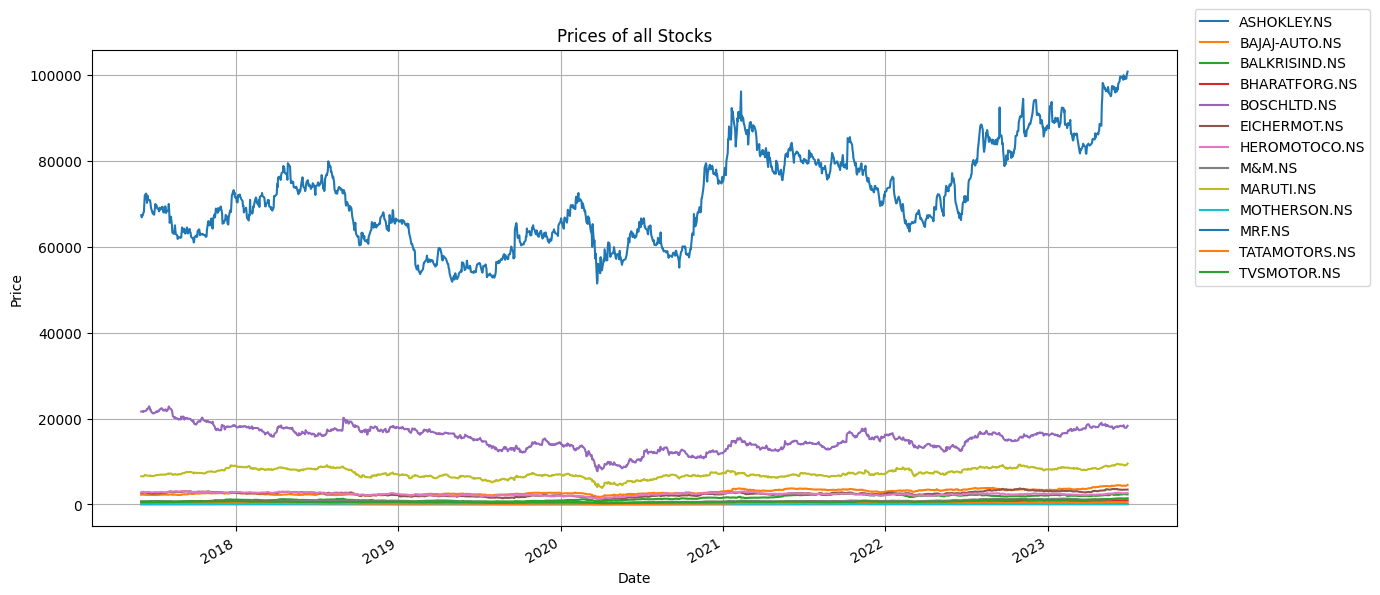

In [6]:
# Plotting the prices
close_prices.plot(figsize=(14, 7))

# Add plot title and labels
plt.title("Prices of all Stocks")
plt.xlabel("Date")
plt.ylabel("Price")

# Place legend outside the plot
plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)

# Show the plot
plt.grid(True)
plt.show()


There is a vast difference in the stock prices of all the stocks, hence, we will use a log transformation.

## Log Transformation

In [7]:
# Apply log transformation to prices
log_prices = np.log(close_prices)

print("Sample of Log Price data (Head):")
display(log_prices.head())


Sample of Log Price data (Head):


Ticker,ASHOKLEY.NS,BAJAJ-AUTO.NS,BALKRISIND.NS,BHARATFORG.NS,BOSCHLTD.NS,EICHERMOT.NS,HEROMOTOCO.NS,M&M.NS,MARUTI.NS,MOTHERSON.NS,MRF.NS,TATAMOTORS.NS,TVSMOTOR.NS
Date,,,,,,,,,,,,,
2017-06-01,3.654752,7.710748,6.597393,6.338130,9.981857,7.894948,7.949092,6.486153,8.790333,3.887897,11.117645,6.148938,6.235305
2017-06-02,3.673780,7.715491,6.580531,6.327542,9.981355,7.908288,7.979794,6.481406,8.785859,3.901304,11.110268,6.153334,6.247502
2017-06-05,3.675394,7.731331,6.590346,6.322543,9.984834,7.913259,7.975942,6.485065,8.787404,3.902184,11.119358,6.152080,6.251381
2017-06-06,3.662951,7.722721,6.595975,6.305039,9.976857,7.908669,7.966774,6.476423,8.785494,3.908760,11.126448,6.115553,6.239978
2017-06-07,3.672702,7.723573,6.586183,6.341979,9.984891,7.926393,7.978104,6.490808,8.798568,3.916161,11.128849,6.109024,6.239791


### Visualizing the log price series

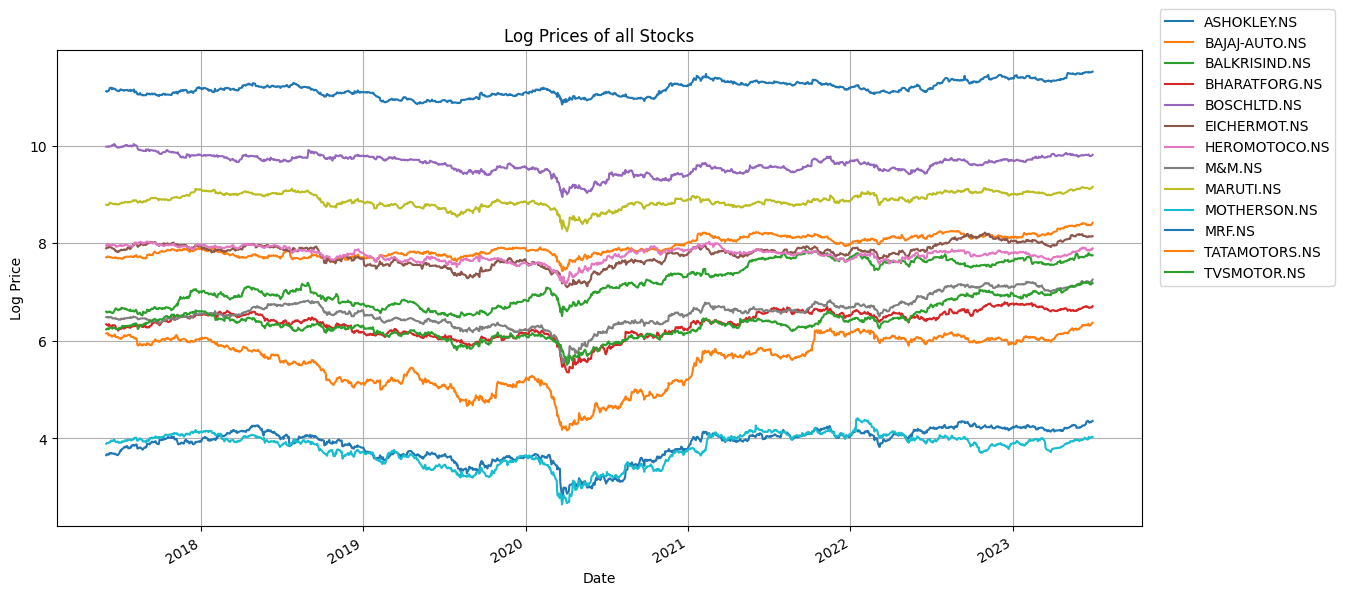

In [8]:
# Plotting the prices
log_prices.plot(figsize=(14, 7))

# Add plot title and labels
plt.title("Log Prices of all Stocks")
plt.xlabel("Date")
plt.ylabel("Log Price")

# Place legend outside the plot
plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)

# Show the plot
plt.grid(True)
plt.show()

## Stationarity Analysis

### Augmented Dickey Fuller (ADF) Test

In [9]:
# Select a stock for testing
representative_stock = log_prices.iloc[:, 0]

# Perform ADF test on log prices
stat_y, p_y, _, _, _, _ = adfuller(representative_stock)
print("Augmented Dickey Fuller test for log prices of Stock Y")
print(f"ADF Statistic: {stat_y:.4f}")
print(f"P-Value: {p_y:.4f} (P > 0.1 confirms Non Stationarity)")

# Calculate log returns
representative_stock_returns = representative_stock.diff().dropna()
# representative_stock_returns[i] = representative_stock[i] - representative_stock[i-1]

# Perform ADF test on log returns
stat_ret_y, p_ret_y, _, _, _, _ = adfuller(representative_stock_returns)
print("\nAugmented Dickey Fuller test for log returns of Stock Y")
print(f"ADF Statistic: {stat_ret_y:.4f}")
print(f"P-Value: {p_ret_y:.4f} (P < 0.1 confirms Stationarity)")

Augmented Dickey Fuller test for log prices of Stock Y
ADF Statistic: -1.4506
P-Value: 0.5578 (P > 0.1 confirms Non Stationarity)

Augmented Dickey Fuller test for log returns of Stock Y
ADF Statistic: -36.7671
P-Value: 0.0000 (P < 0.1 confirms Stationarity)


## Correlation Analysis

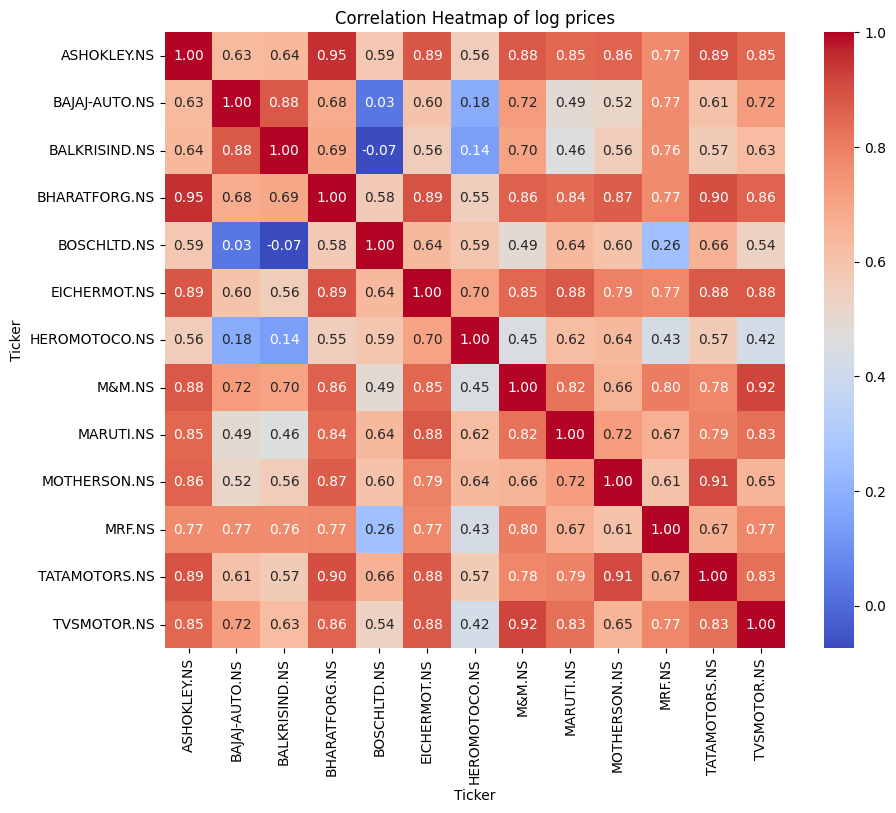

In [10]:
# Plotting a heatmap of the log price series
plt.figure(figsize=(10, 8))
sns.heatmap(log_prices.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of log prices")
plt.show()

## Engle-Granger Cointegration test

In [11]:
def perform_eg_test(Y, X):
    """
    Perform the Engle-Granger cointegration test on two time series.
    """

    # Step 1: Ordinary Least Squares regression to find the hedge ratio and intercept
    # using statsmodel library
    X_with_constant = sm.add_constant(X)
    model = sm.OLS(Y, X_with_constant)
    results = model.fit()
    beta = results.params[1]
    constant = results.params[0]
    residuals = Y - (X * beta + constant) # Calculate residuals (the spread)

    # Step 2: ADF test on the residuals to check for stationarity
    adf_result = adfuller(residuals)
    pvalue = adf_result[1]


    return beta, constant, pvalue

Dividing the entire dataset into test and train (80:20 Split)

In [12]:
# 80% Train, 20% Test sets
split_index = int(len(log_prices) * 0.8)

# Segment into training and testing components
train_log_prices = log_prices[:split_index]
test_log_prices = log_prices[split_index:]

train_close_prices = close_prices[:split_index]
test_close_prices = close_prices[split_index:]

print(f"Full series length: {len(log_prices)} days.")
print(f"Training Period (Selection/Initial Fit): {train_log_prices.index[0].strftime('%Y-%m-%d')} to {train_log_prices.index[-1].strftime('%Y-%m-%d')} ({len(train_log_prices)} days).")
print(f"Testing Period (Trading Simulation): {test_log_prices.index[0].strftime('%Y-%m-%d')} to {test_log_prices.index[-1].strftime('%Y-%m-%d')} ({len(test_log_prices)} days).")


Full series length: 1504 days.
Training Period (Selection/Initial Fit): 2017-06-01 to 2022-04-12 (1203 days).
Testing Period (Trading Simulation): 2022-04-13 to 2023-06-30 (301 days).


Testing across all possible pairs

In [13]:
# List of all the stocks
tickers = train_log_prices.columns

# Initializing a list to store cointegration results
cointegration_results = []

# Total number of unique pairs
n_stocks = len(tickers)
n_pairs = n_stocks * (n_stocks - 1) / 2

# Iterate through all possible pairs
for i in range(n_stocks):
    for j in range(i + 1, n_stocks):
        # get the tickers
        stock_y_ticker = tickers[i]
        stock_x_ticker = tickers[j]

        # get ticker data
        Y = train_log_prices[stock_y_ticker]
        X = train_log_prices[stock_x_ticker]

        # Engle-Granger test
        beta, constant, pvalue = perform_eg_test(Y, X)

        # Store the results
        cointegration_results.append({
            'Pair (Y/X)': f"{stock_y_ticker} / {stock_x_ticker}",
            'OLS Hedge Ratio (η^​)': beta,
            'ADF P-Value of the residual': pvalue,
            'Stationarity Confirmation': 'I(0) / Reject H_0' if pvalue < 0.10 else 'I(1) / Fail to Reject H_0'
        })


# Finally store the results in a dataframe for better access
results_df = pd.DataFrame(cointegration_results)

# Filter for statistically significant pairs (p-value < 0.10)
significant_pairs = (
    results_df[results_df['ADF P-Value of the residual'] < 0.10]
    .sort_values(by='ADF P-Value of the residual')
    .reset_index(drop=True)
)

# Print the number of cointegrated pairs found
n_cointegrated = len(significant_pairs)
print(f"Found {n_cointegrated} statistically significant cointegrated pairs (P < 0.10).")
display(significant_pairs.round(4))

Found 27 statistically significant cointegrated pairs (P < 0.10).


,Pair (Y/X),OLS Hedge Ratio (η^​),ADF P-Value of the residual,Stationarity Confirmation
0,ASHOKLEY.NS / BHARATFORG.NS,1.1256,0.0000,I(0) / Reject H_0
1,MOTHERSON.NS / TVSMOTOR.NS,1.5576,0.0000,I(0) / Reject H_0
2,TATAMOTORS.NS / TVSMOTOR.NS,2.2833,0.0001,I(0) / Reject H_0
3,MOTHERSON.NS / TATAMOTORS.NS,0.6394,0.0003,I(0) / Reject H_0
4,BHARATFORG.NS / MOTHERSON.NS,0.6929,0.0003,I(0) / Reject H_0
5,ASHOKLEY.NS / TVSMOTOR.NS,1.3199,0.0013,I(0) / Reject H_0
6,BHARATFORG.NS / TVSMOTOR.NS,1.1315,0.0019,I(0) / Reject H_0
7,ASHOKLEY.NS / MOTHERSON.NS,0.7962,0.0029,I(0) / Reject H_0
8,EICHERMOT.NS / TVSMOTOR.NS,0.8546,0.0030,I(0) / Reject H_0
9,EICHERMOT.NS / MOTHERSON.NS,0.5073,0.0031,I(0) / Reject H_0


### Selecting a cointegrated pair for pairs trading

In [14]:
# Extract individual stock tickers
best_pair = significant_pairs.loc[0, 'Pair (Y/X)']
ticker_y, ticker_x = best_pair.split(' / ')
eta, constant = significant_pairs.loc[0, ['OLS Hedge Ratio (η^​)', 'ADF P-Value of the residual']]

print(f"Ticker X: {ticker_x}")
print(f"Ticker Y: {ticker_y}")
print(f"OLS Hedge Ratio (η^​): {eta:.4f}")
print(f"Constant:{constant:.4f}")

Ticker X: BHARATFORG.NS
Ticker Y: ASHOKLEY.NS
OLS Hedge Ratio (η^​): 1.1256
Constant:0.0000


Visualizing the individual log prices

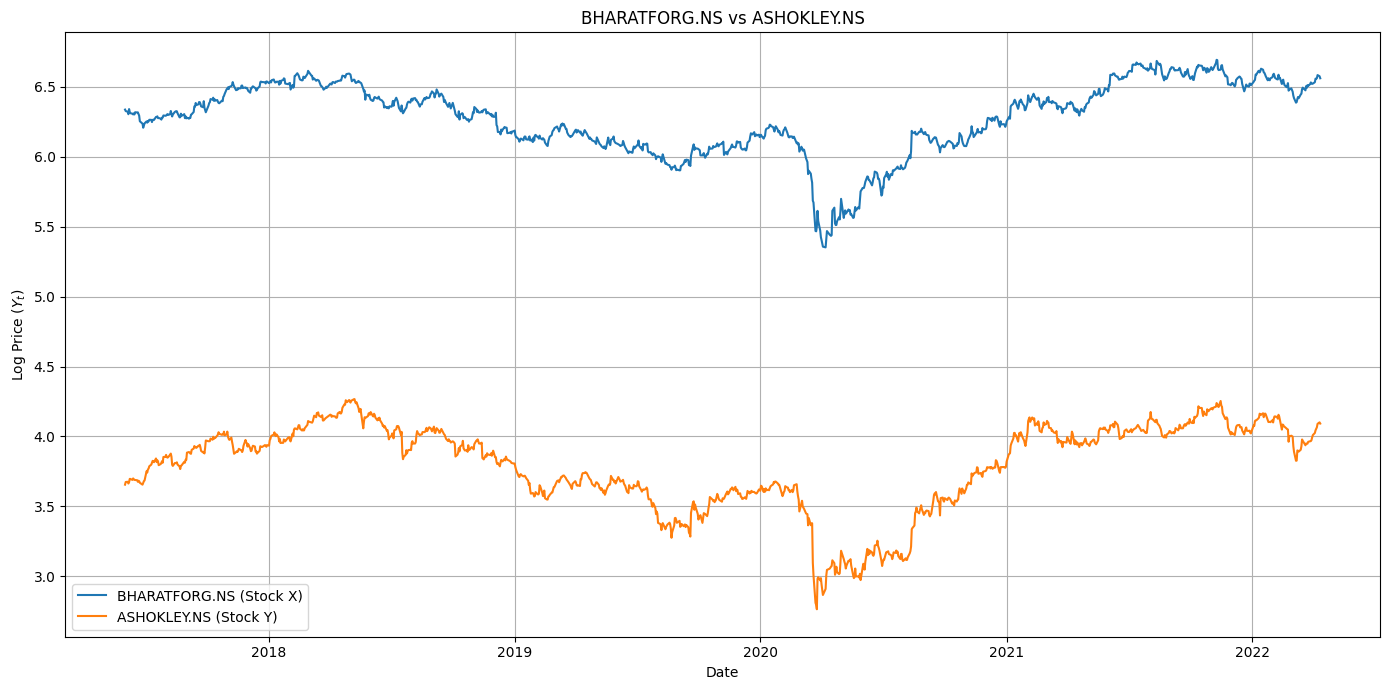

In [15]:
# Create the plot
plt.figure(figsize=(14, 7))

# Plot both time series
plt.plot(train_log_prices.index, train_log_prices[ticker_x], label=f'{ticker_x} (Stock X)')
plt.plot(train_log_prices.index, train_log_prices[ticker_y], label=f'{ticker_y} (Stock Y)')

# Add labels and title
plt.title(f'{ticker_x} vs {ticker_y}')
plt.xlabel('Date')
plt.ylabel('Log Price ($Y_t$)')

# Add legend
plt.legend()

# Add grid layout
plt.grid(True)

# Improve layout
plt.tight_layout()

## ARIMA Modelling (of individual stocks) - Univariate Benchmark

### Train-Test Split

Full series length: 1504 days.
Training Period (Selection/Initial Fit): 2017-06-01 to 2022-04-12 (1203 days).
Testing Period (Trading Simulation): 2022-04-13 to 2023-06-30 (301 days).


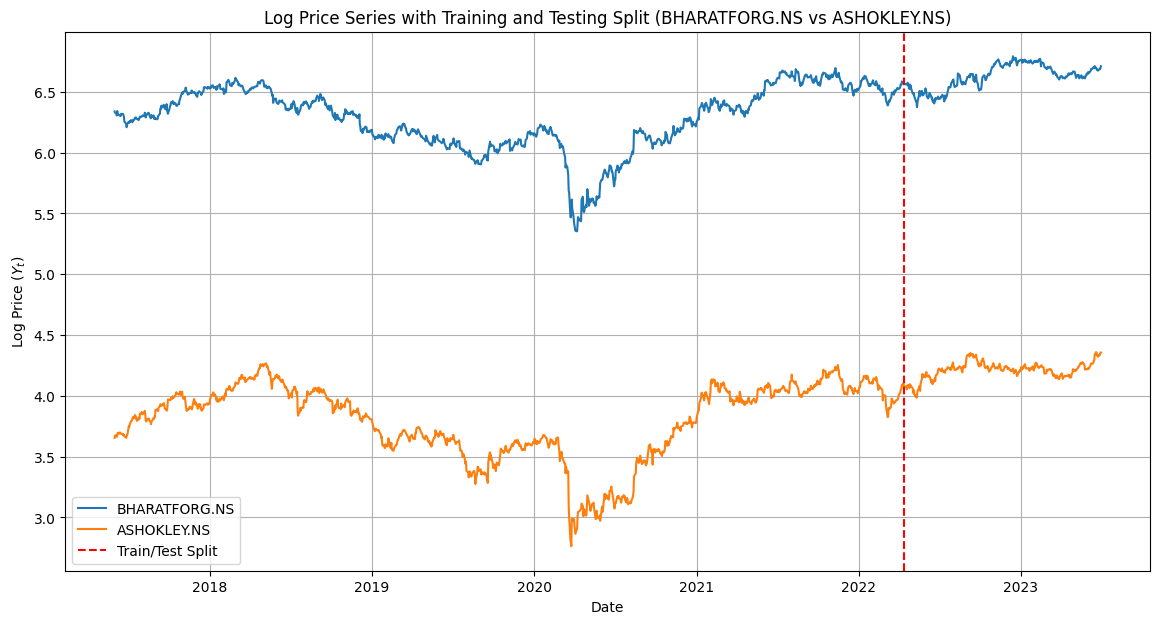

In [16]:
# 80% Train, 20% Test sets
split_index = int(len(log_prices) * 0.8)

# Extract the full log price series for the selected stocks
x_full = log_prices[ticker_x]
y_full = log_prices[ticker_y]

# Segment into training and testing components
x_train_series = x_full[:split_index]
x_test_series = x_full[split_index:]

y_train_series = y_full[:split_index]
y_test_series = y_full[split_index:]

print(f"Full series length: {len(x_full)} days.")
print(f"Training Period (Selection/Initial Fit): {x_train_series.index[0].strftime('%Y-%m-%d')} to {x_train_series.index[-1].strftime('%Y-%m-%d')} ({len(x_train_series)} days).")
print(f"Testing Period (Trading Simulation): {x_test_series.index[0].strftime('%Y-%m-%d')} to {x_test_series.index[-1].strftime('%Y-%m-%d')} ({len(x_test_series)} days).")

# Plot the full series, highlighting the train and test segments
plt.figure(figsize=(14, 7))
plt.plot(log_prices.index, log_prices[ticker_x], label=f'{ticker_x}')
plt.plot(log_prices.index, log_prices[ticker_y], label=f'{ticker_y}')
plt.axvline(x_train_series.index[-1], color='r', linestyle='--', label='Train/Test Split')
plt.title(f"Log Price Series with Training and Testing Split ({ticker_x} vs {ticker_y})")
plt.xlabel("Date")
plt.ylabel("Log Price ($Y_t$)")
plt.grid(True)
plt.legend()

plt.show()

Confirming Stationarity

In [17]:
# Perform ADF test on log prices
stat_x, p_x, _, _, _, _ = adfuller(x_full)
print(f"Augmented Dickey Fuller test for log prices of {ticker_x}")
print(f"ADF Statistic: {stat_x:.4f}\nP-Value: {p_x:.4f} (P > 0.1 confirms Non Stationarity)")

# Perform ADF test on log returns
x_log_returns = x_full.diff().dropna()

stat_ret_x, p_ret_x, _, _, _, _ = adfuller(x_log_returns)
print(f"\nAugmented Dickey Fuller test for log returns of {ticker_x}")
print(f"ADF Statistic: {stat_ret_x:.4f}\nP-Value: {p_ret_x:.4f} (P < 0.1 confirms Stationarity)\n")


# Perform ADF test on log prices
stat_y, p_y, _, _, _, _ = adfuller(y_full)
print(f"Augmented Dickey Fuller test for log prices of {ticker_y}")
print(f"ADF Statistic: {stat_y:.4f}\nP-Value: {p_y:.4f} (P > 0.1 confirms Non Stationarity)")

# Perform ADF test on log returns
y_log_returns = y_full.diff().dropna()

stat_ret_y, p_ret_y, _, _, _, _ = adfuller(y_log_returns)
print(f"\nAugmented Dickey Fuller test for log returns of {ticker_y}")
print(f"ADF Statistic: {stat_ret_y:.4f}\nP-Value: {p_ret_y:.4f} (P < 0.1 confirms Stationarity)")

Augmented Dickey Fuller test for log prices of BHARATFORG.NS
ADF Statistic: -1.3791
P-Value: 0.5923 (P > 0.1 confirms Non Stationarity)

Augmented Dickey Fuller test for log returns of BHARATFORG.NS
ADF Statistic: -38.6534
P-Value: 0.0000 (P < 0.1 confirms Stationarity)

Augmented Dickey Fuller test for log prices of ASHOKLEY.NS
ADF Statistic: -1.4506
P-Value: 0.5578 (P > 0.1 confirms Non Stationarity)

Augmented Dickey Fuller test for log returns of ASHOKLEY.NS
ADF Statistic: -36.7671
P-Value: 0.0000 (P < 0.1 confirms Stationarity)


Autocorrelation and Partial Autocorrelation Visualization

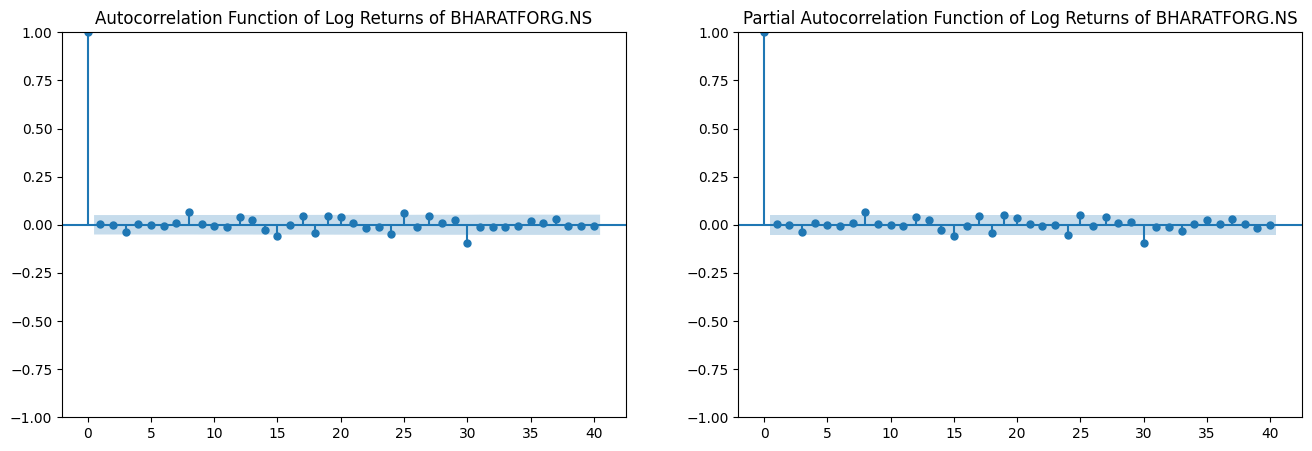

In [18]:
# Create subplots for ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot ACF on the first axis
sm.graphics.tsa.plot_acf(x_log_returns, ax=axes[0], lags=40)
axes[0].set_title(f"Autocorrelation Function of Log Returns of {ticker_x}")

# Plot PACF on the second axis
sm.graphics.tsa.plot_pacf(x_log_returns, ax=axes[1], lags=40)
axes[1].set_title(f"Partial Autocorrelation Function of Log Returns of {ticker_x}")

plt.show()

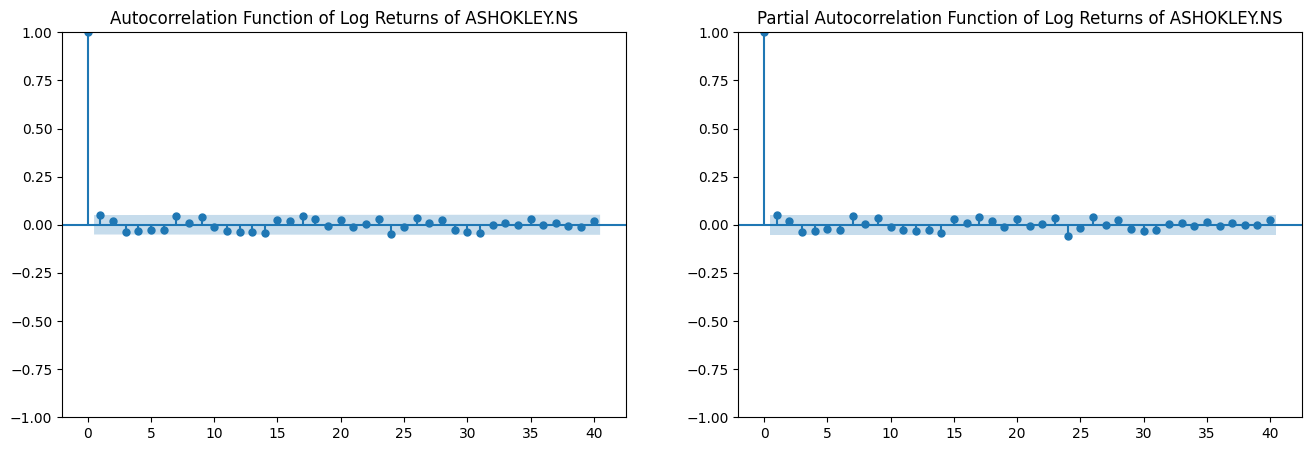

In [19]:
# Create subplots for ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot ACF on the first axis
sm.graphics.tsa.plot_acf(y_log_returns, ax=axes[0], lags=40)
axes[0].set_title(f"Autocorrelation Function of Log Returns of {ticker_y}")

# Plot PACF on the second axis
sm.graphics.tsa.plot_pacf(y_log_returns, ax=axes[1], lags=40)
axes[1].set_title(f"Partial Autocorrelation Function of Log Returns of {ticker_y}")

plt.show()

ARIMA Modelling

In [20]:
# auto_arima to find the best ARIMA model
y_best_model = pm.auto_arima(y_train_series,
                           d=1,
                           start_p=0,
                           start_q=0,
                           max_p=10,
                           max_q=10,
                           stepwise=True,
                           trace=True,                  # Print results of each step
                           seasonal=False,              # No seasonality assumed
                           information_criterion='aic') # Use AIC for model selection

# Store the resulting model summary
y_model_summary = y_best_model.summary()
print(y_model_summary)

# Extract optimal parameters
y_optimal_p, y_optimal_d, y_optimal_q = y_best_model.order
print(f"\nThe selected ARIMA({y_optimal_p}, {y_optimal_d}, {y_optimal_q}) model will be used for modelling the stock {ticker_y}.")

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5095.487, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5098.305, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5098.111, Time=1.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5097.299, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5096.633, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5096.433, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5094.687, Time=0.61 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5100.138, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-5098.471, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5098.270, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5099.936, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-5097.066, Time=0.53 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 3.893 seconds
                               SARIMAX Results                              

In [21]:
# auto_arima to find the best ARIMA model
x_best_model = pm.auto_arima(x_train_series,
                           d=1,
                           start_p=0,
                           start_q=0,
                           max_p=10,
                           max_q=10,
                           stepwise=True,               # Use stepwise search
                           trace=True,                  # Print results of each step
                           seasonal=False,              # No seasonality assumed
                           information_criterion='aic') # Use Akaike's Information Criterion for model selection

# Store the resulting model summary
x_model_summary = x_best_model.summary()
print(x_model_summary)

# Extract optimal parameters
x_optimal_p, x_optimal_d, x_optimal_q = x_best_model.order
print(f"\nThe selected ARIMA({x_optimal_p}, {x_optimal_d}, {x_optimal_q}) model will be used for modelling the stock {ticker_x}.")

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5526.205, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5524.250, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5524.250, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5528.134, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5522.289, Time=0.64 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.054 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1203
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2765.067
Date:                Sat, 08 Nov 2025   AIC                          -5528.134
Time:                        11:09:28   BIC                          -5523.042
Sample:                             0   HQIC                         -5526.216
                               - 1203                                  

# Pairs Trading Strategies

# Static Hedge Ratio

Visualization of the Selected Pair’s Residual Spread

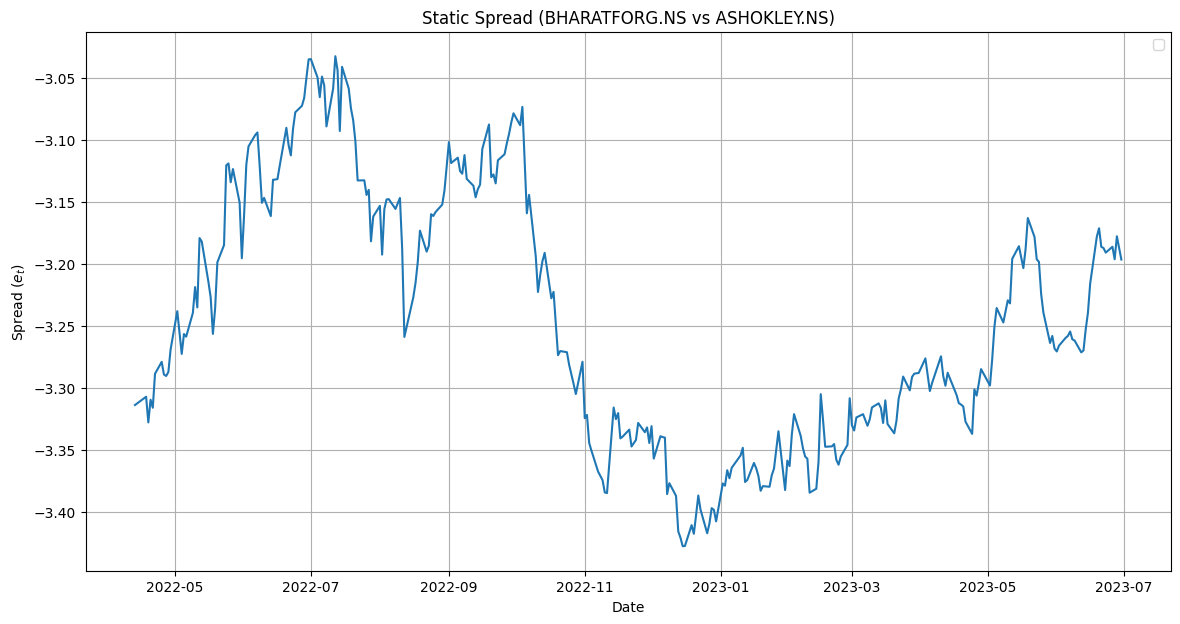

In [22]:
# Get the log prices for the selected pair
Y = test_log_prices[ticker_y]
X = test_log_prices[ticker_x]

# Static Spread
spread = Y - (X * eta + constant)

# Dropping any NaN values
spread.dropna(inplace=True)

# Plot the full spread series
plt.figure(figsize=(14, 7))
plt.plot(spread.index, spread)
plt.title(f"Static Spread ({ticker_x} vs {ticker_y})")
plt.xlabel("Date")
plt.ylabel("Spread ($e_t$)")
plt.grid(True)
plt.legend()

plt.show()

Finding out the Z-score of the residual spread

In [23]:
ZSCORE_WINDOW = 60  # Window size for rolling Z-score calculation
K_ENTER = 1.5       # Z-score entry threshold
K_EXIT = 0.25        # Z-score exit threshold

print(f"Z-score signal calculation window: {ZSCORE_WINDOW} days")
print(f"Entry Threshold (k_enter): |Z| > {K_ENTER} sigma")
print(f"Exit Threshold (k_exit): |Z| < {K_EXIT} sigma.")

Z-score signal calculation window: 60 days
Entry Threshold (k_enter): |Z| > 1.5 sigma
Exit Threshold (k_exit): |Z| < 0.25 sigma.


In [24]:
# Calculate the rolling mean and standard deviation of the spread
rolling_mean = spread.rolling(window=ZSCORE_WINDOW).mean()
rolling_std = spread.rolling(window=ZSCORE_WINDOW).std()

# Calculate the Z-score of the spread
zscore = (spread - rolling_mean) / rolling_std


Visualizing the Z-score thresholds

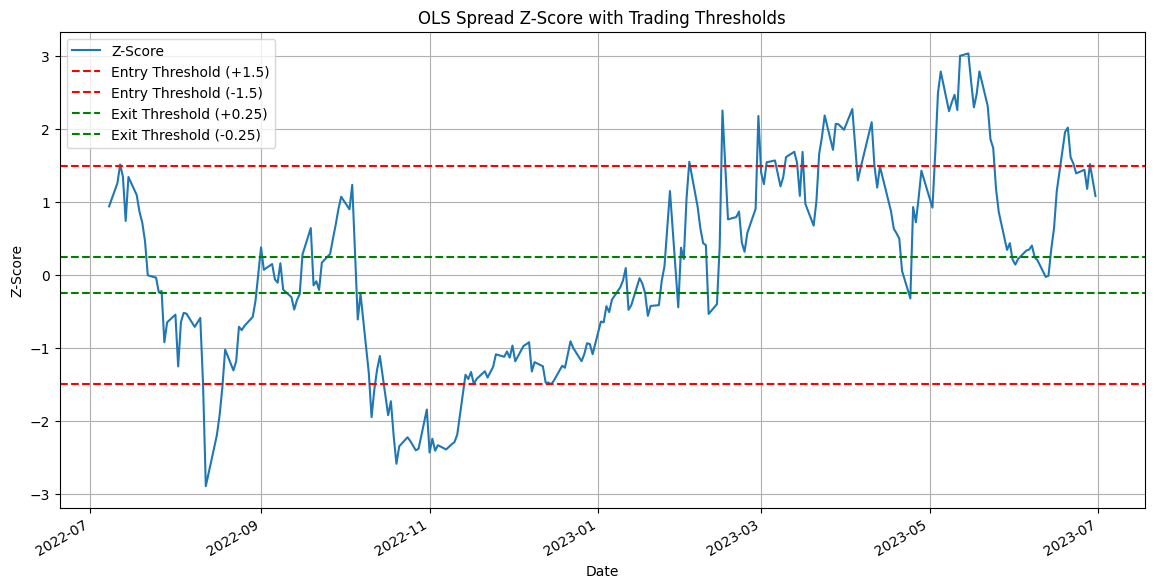

In [25]:
plt.figure(figsize=(14, 7))
zscore.plot(label='Z-Score')

# Add plot title and labels
plt.title("OLS Spread Z-Score with Trading Thresholds")
plt.xlabel("Date")
plt.ylabel("Z-Score")

# Add horizontal lines for trading thresholds
plt.axhline(K_ENTER, color='red', linestyle='--', label=f'Entry Threshold (+{K_ENTER})')
plt.axhline(-K_ENTER, color='red', linestyle='--', label=f'Entry Threshold (-{K_ENTER})')
plt.axhline(K_EXIT, color='green', linestyle='--', label=f'Exit Threshold (+{K_EXIT})')
plt.axhline(-K_EXIT, color='green', linestyle='--', label=f'Exit Threshold (-{K_EXIT})')

# Add legend
plt.legend()
plt.grid(True)
plt.show()

<h3>Backtesting framework and trade execution</h3>

Portfolio tracking and Trade logs

In [26]:
INITIAL_CAPITAL = 100000

print(f"Initial Capital Set: ₹{INITIAL_CAPITAL:,.2f}")

# Initialize DataFrame to track portfolio metrics
portfolio = pd.DataFrame(index=zscore.index)
portfolio['portfolio_value'] = INITIAL_CAPITAL
portfolio['shares_y'] = 0
portfolio['shares_x'] = 0
portfolio['position'] = 0 # 1 for long (long y, short x), -1 for short (short y, long x), 0 for flat
portfolio['trades'] = 0
portfolio['daily_return'] = 0

# Initialize a list to store trade log details
trade_log = []

Initial Capital Set: ₹100,000.00


Transaction Cost Modelling

In [27]:
C_FIXED_PCT = 0.0005  # Fixed costs (e.g., brokerage, statutory fees) as a percentage of turnover
ALPHA = 0.0005        # Variable costs (e.g., slippage, market impact) as a percentage of turnover

print("--- Transaction Cost Modeling Setup ----")
print(f"Fixed Costs (Brokerage/Fees): {C_FIXED_PCT:.2%} of Turnover.")
print(f"Variable Costs (Slippage/Impact): {ALPHA:.2%} of Turnover.")
print("Total cost is applied to both the long and short legs of the spread trade.")

--- Transaction Cost Modeling Setup ----
Fixed Costs (Brokerage/Fees): 0.05% of Turnover.
Variable Costs (Slippage/Impact): 0.05% of Turnover.
Total cost is applied to both the long and short legs of the spread trade.


Rolling Walk-forward backtesting

In [28]:
# Get the price series for the selected pair
price_y = test_close_prices[ticker_y]
price_x = test_close_prices[ticker_x]

# Ensure all series are aligned before backtesting.
aligned_data = pd.DataFrame({
    'price_y': price_y,
    'price_x': price_x,
    'zscore': zscore
})

# Get the index for iteration (dates)
backtest_index = aligned_data.index

In [29]:
# Iterate through the aligned data
for i in range(1, len(aligned_data)):
    date_t = backtest_index[i]

    # State carry-over from previous day
    portfolio.loc[date_t] = portfolio.iloc[i-1]

    # Get values for today
    z_t = aligned_data['zscore'].loc[date_t]
    price_y_t = aligned_data['price_y'].loc[date_t]
    price_x_t = aligned_data['price_x'].loc[date_t]

    # Get previous day's values
    prev_date_t = backtest_index[i-1]
    prev_price_y_t = aligned_data['price_y'].loc[prev_date_t]
    prev_price_x_t = aligned_data['price_x'].loc[prev_date_t]

    # Get previous day's state
    prev_pos_status = portfolio.loc[prev_date_t, 'position']
    prev_shares_y = portfolio.loc[prev_date_t, 'shares_y']
    prev_shares_x = portfolio.loc[prev_date_t, 'shares_x']
    prev_portfolio_value = portfolio.loc[prev_date_t, 'portfolio_value']

    # PnL calculation
    daily_pnl = 0.0
    if prev_pos_status != 0:
        daily_pnl = (prev_shares_y * (price_y_t - prev_price_y_t)) + (prev_shares_x * (price_x_t - prev_price_x_t))

    # Update portfolio value with today's Market to Market PnL
    portfolio.loc[date_t, 'portfolio_value'] = prev_portfolio_value + daily_pnl

    # Exit Signal
    if prev_pos_status == 1 and z_t > K_EXIT: # Exit Long
        # Transaction Costs
        cost = (C_FIXED_PCT + ALPHA) * (prev_shares_y * price_y_t + abs(prev_shares_x) * price_x_t)
        portfolio.loc[date_t, 'portfolio_value'] -= cost

        # Finding the original entry of the current trade
        entry_trade = next((trade for trade in reversed(trade_log) if trade['Type'].startswith('Entry')), None)
        gross_pnl = 0
        if entry_trade:
            gross_pnl = (price_y_t - entry_trade['Price Y']) * entry_trade['Shares Y'] + (entry_trade['Price X'] - price_x_t) * entry_trade['Shares X']

        # Log the trade
        trade_log.append({
            'Date': date_t,
            'Type': 'Exit - Long Spread',
            'Z-Score': z_t,
            'Shares Y': 0,
            'Shares X': 0,
            'Price Y': price_y_t,
            'Price X': price_x_t,
            'Hedge Ratio': eta,
            'Transaction Cost': cost,
            'Gross PnL': gross_pnl
        })
        print(f"{date_t.date()}: EXIT LONG SPREAD (Z={z_t:.3f}) | Gross PnL: {gross_pnl:,.2f}, Cost: {cost:,.2f}, Net PnL: {gross_pnl - cost:,.2f}")

        # Flatten position
        portfolio.loc[date_t, 'shares_y'] = 0.0
        portfolio.loc[date_t, 'shares_x'] = 0.0
        portfolio.loc[date_t, 'position'] = 0

    elif prev_pos_status == -1 and z_t < -K_EXIT: # Exit Short
        # Transaction Costs
        cost = (C_FIXED_PCT + ALPHA) * (abs(prev_shares_y) * price_y_t + prev_shares_x * price_x_t)
        portfolio.loc[date_t, 'portfolio_value'] -= cost

        # Finding the original entry of the current trade
        entry_trade = next((trade for trade in reversed(trade_log) if trade['Type'].startswith('Entry')), None)
        gross_pnl = 0
        if entry_trade:
             gross_pnl = (entry_trade['Price Y'] - price_y_t) * abs(entry_trade['Shares Y']) + (price_x_t - entry_trade['Price X']) * entry_trade['Shares X']

        # Log the trade
        trade_log.append({
            'Date': date_t,
            'Type': 'Exit - Short Spread',
            'Z-Score': z_t,
            'Shares Y': 0,
            'Shares X': 0,
            'Price Y': price_y_t,
            'Price X': price_x_t,
            'Hedge Ratio': eta,
            'Transaction Cost': cost,
            'Gross PnL': gross_pnl
        })
        print(f"{date_t.date()}: EXIT SHORT SPREAD (Z={z_t:.3f}) | Gross PnL: {gross_pnl:,.2f}, Cost: {cost:,.2f}, Net PnL: {gross_pnl - cost:,.2f}")

        # Flatten position
        portfolio.loc[date_t, 'shares_y'] = 0.0
        portfolio.loc[date_t, 'shares_x'] = 0.0
        portfolio.loc[date_t, 'position'] = 0

    # Entry Signal
    current_pos_status = portfolio.loc[date_t, 'position'] # Recheck status in case we just exited
    if current_pos_status == 0:

        # Portion Size, 50% of our current portfolio value
        current_equity = portfolio.loc[date_t, 'portfolio_value']
        allocation_per_leg = current_equity * 0.5

        # Long Spread (Buy Y, Sell X)
        if z_t < -K_ENTER:
            shares_y = allocation_per_leg // price_y_t
            shares_x = (shares_y * eta * price_y_t) // price_x_t

            # Transaction Costs
            cost = (C_FIXED_PCT + ALPHA) * (shares_y * price_y_t + shares_x * price_x_t)
            portfolio.loc[date_t, 'portfolio_value'] -= cost

            portfolio.loc[date_t, 'shares_y'] = shares_y
            portfolio.loc[date_t, 'shares_x'] = -shares_x
            portfolio.loc[date_t, 'position'] = 1
            portfolio.loc[date_t, 'trades'] += 1

            # Log the trade
            trade_log.append({
                'Date': date_t,
                'Type': 'Entry - Long Spread',
                'Z-Score': z_t,
                'Shares Y': shares_y,
                'Shares X': shares_x,
                'Price Y': price_y_t,
                'Price X': price_x_t,
                'Hedge Ratio': eta,
                'Transaction Cost': cost,
                'Gross PnL': 0
            })
            print(f"{date_t.date()}: ENTER LONG SPREAD (Z={z_t:.3f}) | Buy {shares_y:.0f} {ticker_y}, Sell {shares_x:.0f} {ticker_x}")

        # Short Spread (Sell Y, Buy X)
        elif z_t > K_ENTER:
            shares_y = allocation_per_leg // price_y_t
            shares_x = (shares_y * eta * price_y_t) // price_x_t

            # Transaction Costs
            cost = (C_FIXED_PCT + ALPHA) * (shares_y * price_y_t + shares_x * price_x_t)
            portfolio.loc[date_t, 'portfolio_value'] -= cost

            portfolio.loc[date_t, 'shares_y'] = -shares_y
            portfolio.loc[date_t, 'shares_x'] = shares_x
            portfolio.loc[date_t, 'position'] = -1
            portfolio.loc[date_t, 'trades'] += 1

            trade_log.append({
                'Date': date_t,
                'Type': 'Entry - Short Spread',
                'Z-Score': z_t,
                'Shares Y': shares_y,
                'Shares X': shares_x,
                'Price Y': price_y_t,
                'Price X': price_x_t,
                'Hedge Ratio': eta,
                'Transaction Cost': cost,
                'Gross PnL': 0
            })
            print(f"{date_t.date()}: ENTER SHORT SPREAD (Z={z_t:.3f}) | Sell {shares_y:.0f} {ticker_y}, Buy {shares_x:.0f} {ticker_x}")


    # Final Daily Updates
    portfolio.loc[date_t, 'daily_return'] = (portfolio.loc[date_t, 'portfolio_value'] - prev_portfolio_value) / prev_portfolio_value



2022-07-12: ENTER SHORT SPREAD (Z=1.516) | Sell 753 ASHOKLEY.NS, Buy 91 BHARATFORG.NS
2022-07-28: EXIT SHORT SPREAD (Z=-0.923) | Gross PnL: 8,079.47, Cost: 116.14, Net PnL: 7,963.33
2022-08-12: ENTER LONG SPREAD (Z=-2.897) | Buy 786 ASHOKLEY.NS, Sell 78 BHARATFORG.NS
2022-09-01: EXIT LONG SPREAD (Z=0.379) | Gross PnL: 8,658.28, Cost: 116.97, Net PnL: 8,541.31
2022-10-11: ENTER LONG SPREAD (Z=-1.950) | Buy 837 ASHOKLEY.NS, Sell 86 BHARATFORG.NS
2023-01-27: EXIT LONG SPREAD (Z=1.152) | Gross PnL: -6,850.05, Cost: 130.34, Net PnL: -6,980.40
2023-02-03: ENTER SHORT SPREAD (Z=1.554) | Sell 761 ASHOKLEY.NS, Buy 72 BHARATFORG.NS
2023-02-10: EXIT SHORT SPREAD (Z=-0.534) | Gross PnL: 3,412.47, Cost: 114.57, Net PnL: 3,297.90
2023-02-15: ENTER SHORT SPREAD (Z=2.256) | Sell 804 ASHOKLEY.NS, Buy 77 BHARATFORG.NS
2023-04-24: EXIT SHORT SPREAD (Z=-0.321) | Gross PnL: 1,657.19, Cost: 110.80, Net PnL: 1,546.39
2023-05-03: ENTER SHORT SPREAD (Z=1.663) | Sell 850 ASHOKLEY.NS, Buy 83 BHARATFORG.NS


Plotting the trade signals

In [30]:
def plot_pair_trades(trade_signals, ticker_y, ticker_x):
    fig = plt.figure(figsize=(14, 6),dpi=200)
    bx = fig.add_subplot(111)

    # Plot the Z-score series
    series = bx.plot(trade_signals['zscore'], c='#4abdac')

    # Plot long entry signals as green up arrows
    long_entry = bx.plot(trade_signals['zscore'][trade_signals['long entry'] == True], lw = 0, marker = '^', markersize = 8, c = 'g', alpha = 0.9)

    # Plot long exit signals as orange down arrows
    long_exit = bx.plot(trade_signals['zscore'][trade_signals['long exit'] == True], lw = 0, marker = 'v', markersize = 8, c = 'orange', alpha = 0.9)

    # Plot short entry signals as black up arrows
    short_entry = bx.plot(trade_signals['zscore'][trade_signals["short entry"]== True], lw = 0, marker = '^', markersize = 8, c = 'black', alpha = 0.9)

    # Plot short exit signals as red down arrows
    short_exit = bx.plot(trade_signals['zscore'][trade_signals["short exit"]== True], lw = 0, marker = 'v', markersize = 8, c = 'r', alpha = 0.9)

    # Set the title based on the stock pair (assuming stock_pair is defined globally or passed)
    plt.title(f'Trading signals on ({ticker_y}/{ticker_x}) Spread')

    # Add a legend to the plot
    plt.legend(['Z-Score', 'Long Entry', 'Long Exit','Short Entry',"Short Exit"])
    plt.grid(True)
    plt.ylabel("Z-Score of Spread")
    plt.xlabel("Date")

    # Show the plot
    plt.show()

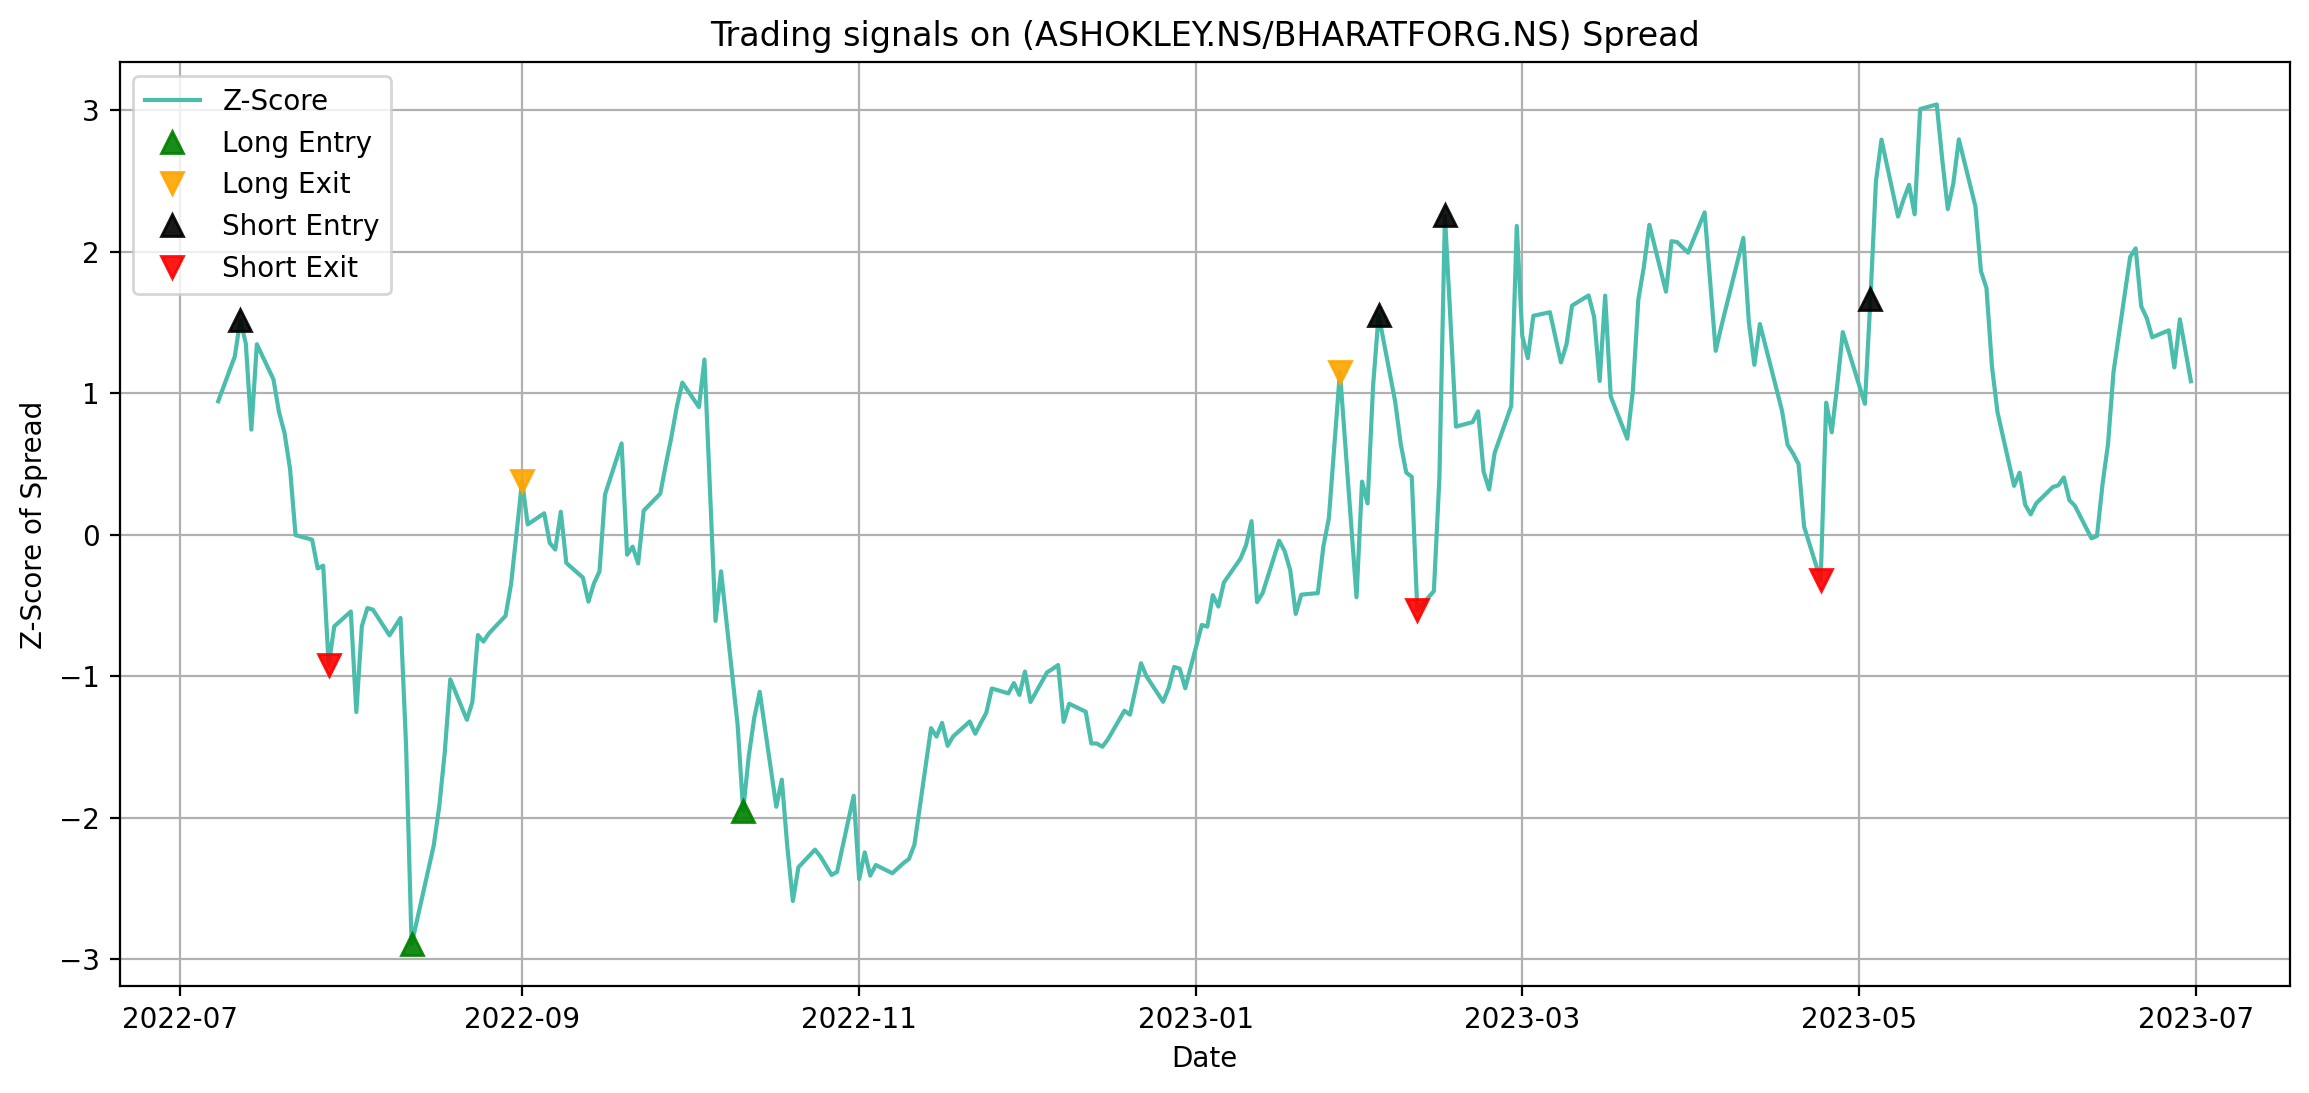

In [31]:
# Add the zscore to the portfolio DataFrame for plotting
portfolio['zscore'] = zscore

# Generate trading signals based on Z-score and thresholds. Add signal columns to the portfolio DataFrame
portfolio['long entry'] = (portfolio['position'].shift(1) == 0) & (portfolio['zscore'] < -K_ENTER)
portfolio['long exit'] = (portfolio['position'].shift(1) == 1) & (portfolio['zscore'] > K_EXIT)
portfolio['short entry'] = (portfolio['position'].shift(1) == 0) & (portfolio['zscore'] > K_ENTER)
portfolio['short exit'] = (portfolio['position'].shift(1) == -1) & (portfolio['zscore'] < -K_EXIT)

plot_pair_trades(portfolio, ticker_y, ticker_x)

Plotting the trade signals on the individual price series

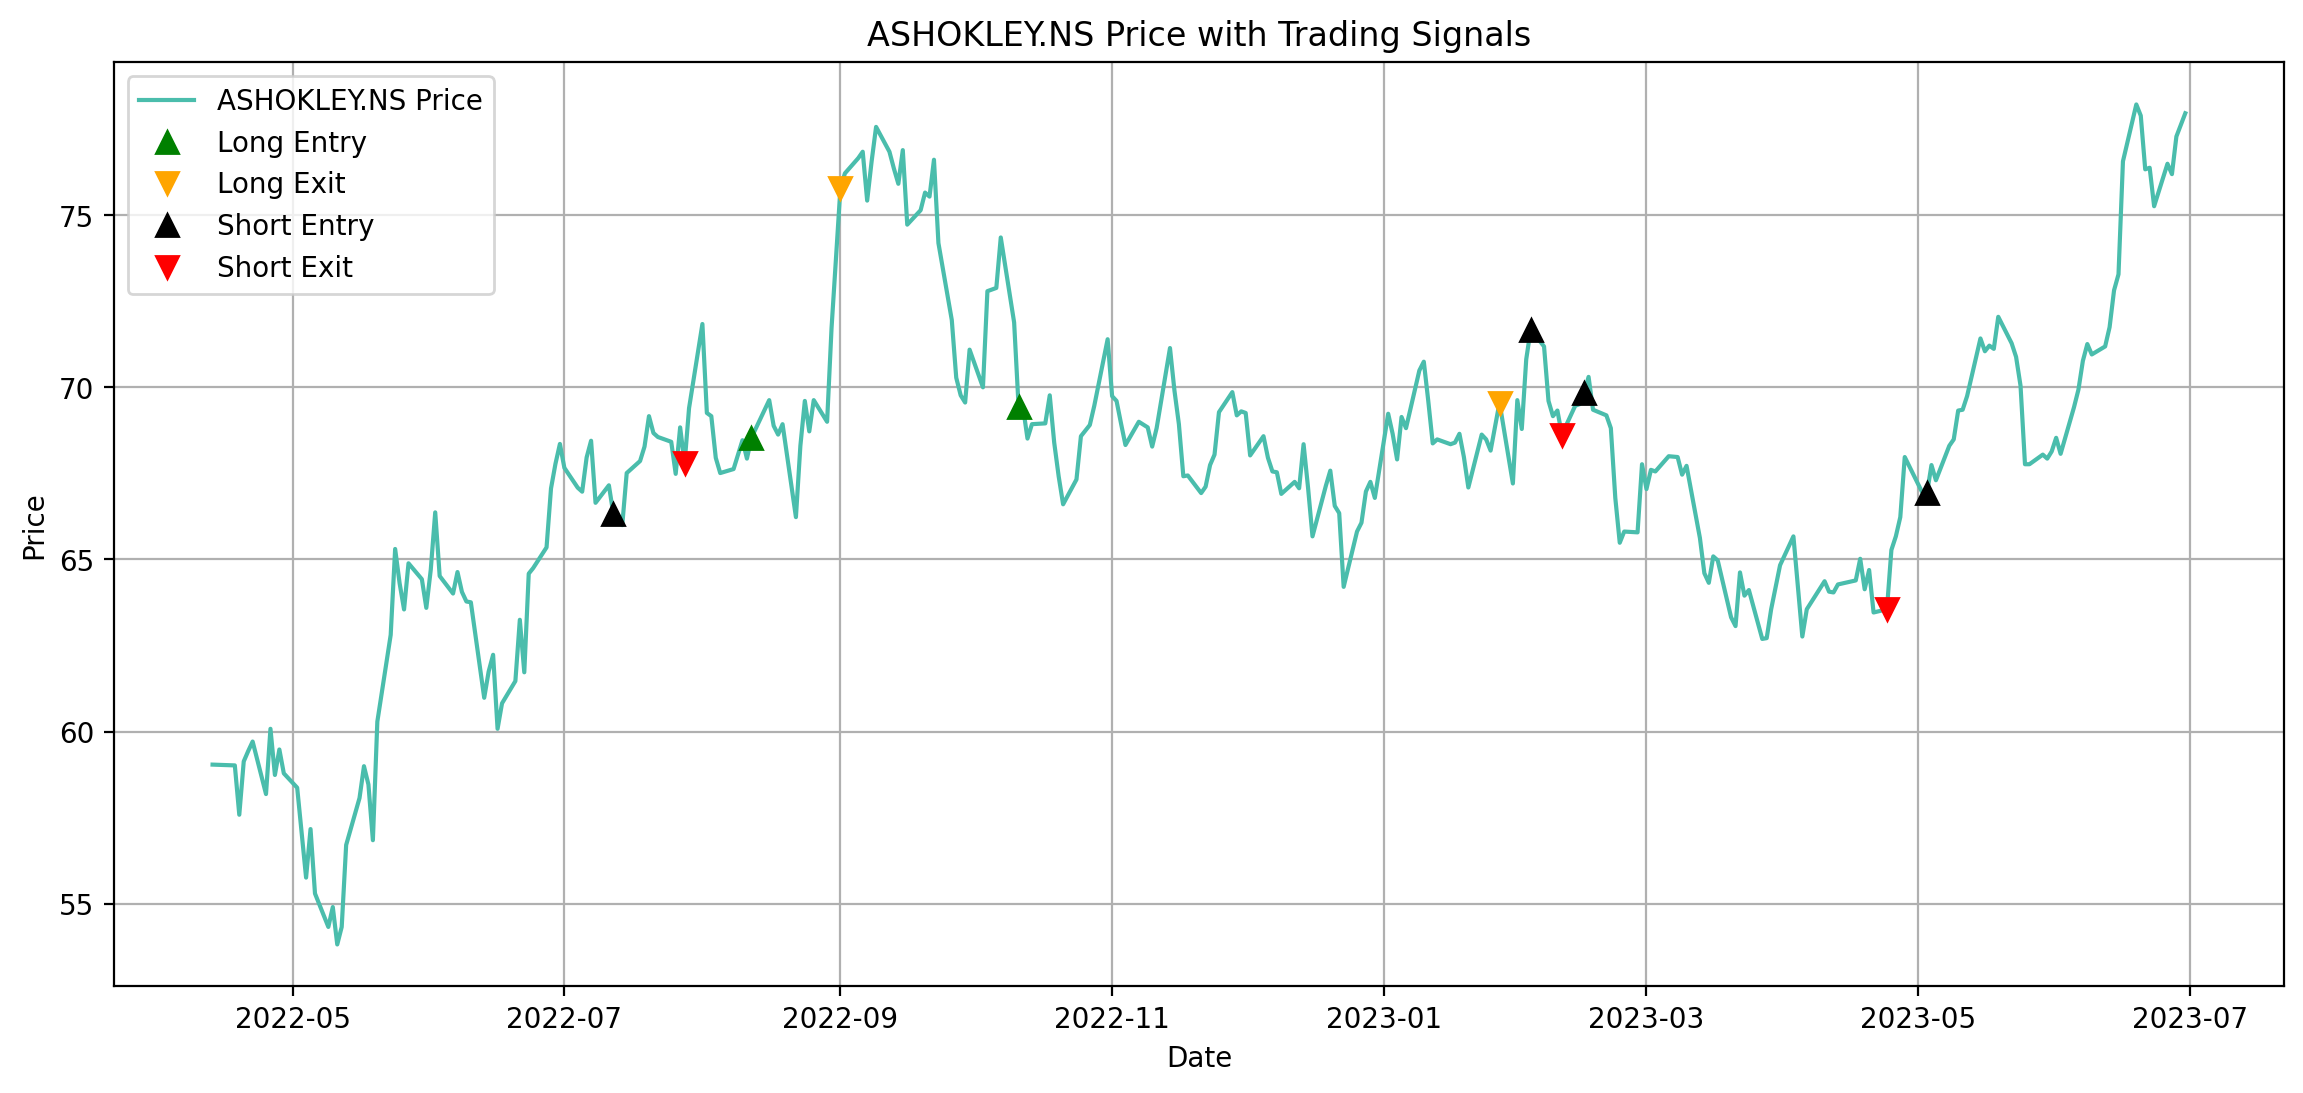

In [32]:
# Individual stock price with trading signals for the Y-Asset
plt.figure(figsize=(14, 6), dpi=200)
plt.plot(aligned_data['price_y'], label=f'{ticker_y} Price', c='#4abdac')

# Mark long entry signals
plt.plot(aligned_data['price_y'][portfolio['long entry']], '^', markersize=8, color='g', lw=0, label='Long Entry')
# Mark long exit signals
plt.plot(aligned_data['price_y'][portfolio['long exit']], 'v', markersize=8, color='orange', lw=0, label='Long Exit')
# Mark short entry signals
plt.plot(aligned_data['price_y'][portfolio['short entry']], '^', markersize=8, color='black', lw=0, label='Short Entry')
# Mark short exit signals
plt.plot(aligned_data['price_y'][portfolio['short exit']], 'v', markersize=8, color='r', lw=0, label='Short Exit')

plt.title(f'{ticker_y} Price with Trading Signals')
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

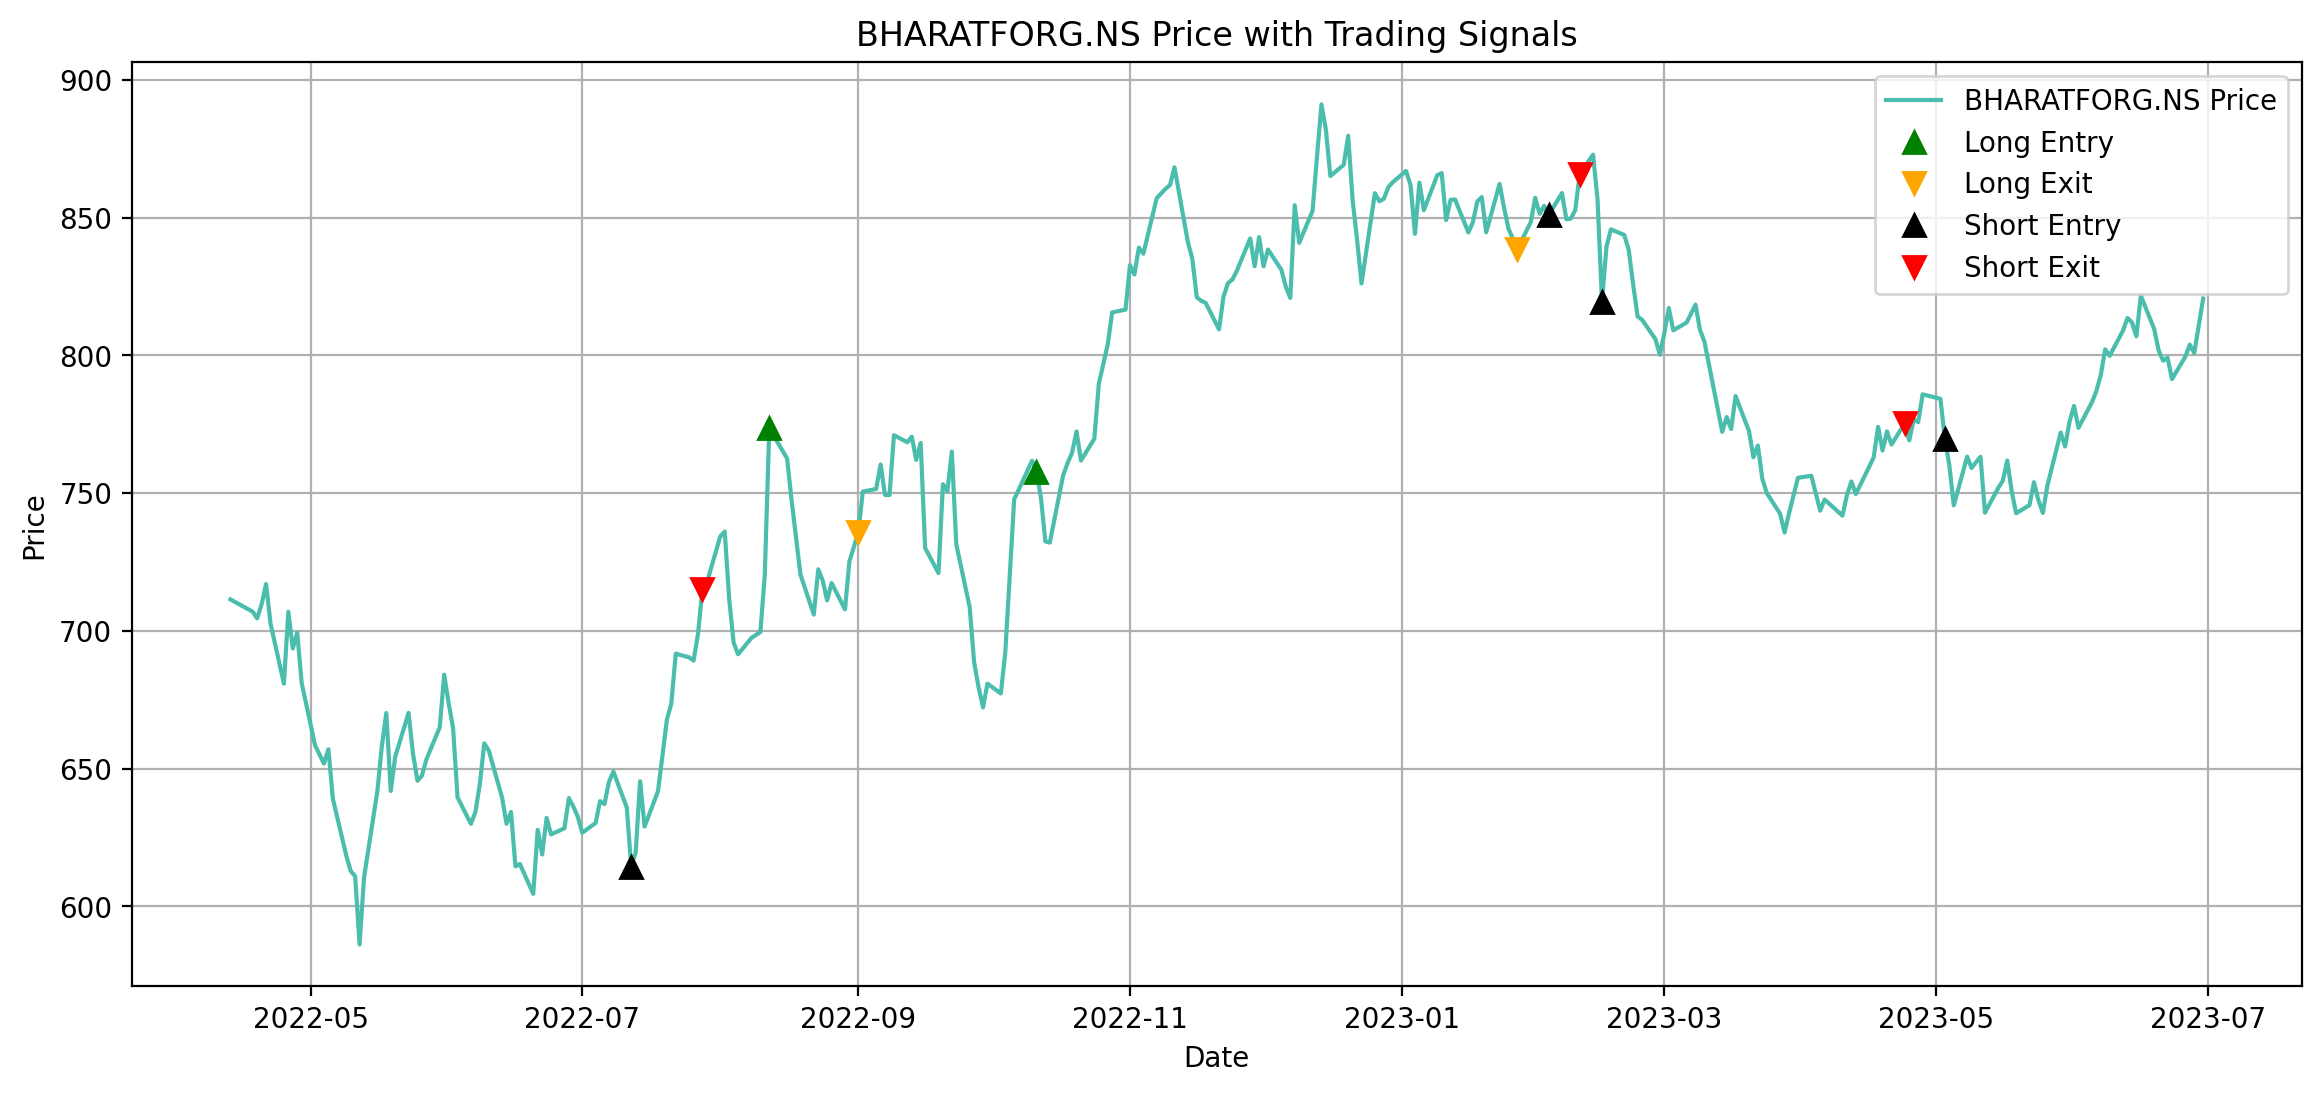

In [33]:
# Individual stock price with trading signals for the X-Asset
plt.figure(figsize=(14, 6), dpi=200)
plt.plot(aligned_data['price_x'], label=f'{ticker_x} Price', c='#4abdac')

# Mark long entry signals
plt.plot(aligned_data['price_x'][portfolio['long entry']], '^', markersize=8, color='g', lw=0, label='Long Entry')

# Mark long exit signals
plt.plot(aligned_data['price_x'][portfolio['long exit']], 'v', markersize=8, color='orange', lw=0, label='Long Exit')

# Mark short entry signals
plt.plot(aligned_data['price_x'][portfolio['short entry']], '^', markersize=8, color='black', lw=0, label='Short Entry')

# Mark short exit signals
plt.plot(aligned_data['price_x'][portfolio['short exit']], 'v', markersize=8, color='r', lw=0, label='Short Exit')

plt.title(f'{ticker_x} Price with Trading Signals')
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# Performance Evaluation

Visualization of the Portfolio Value

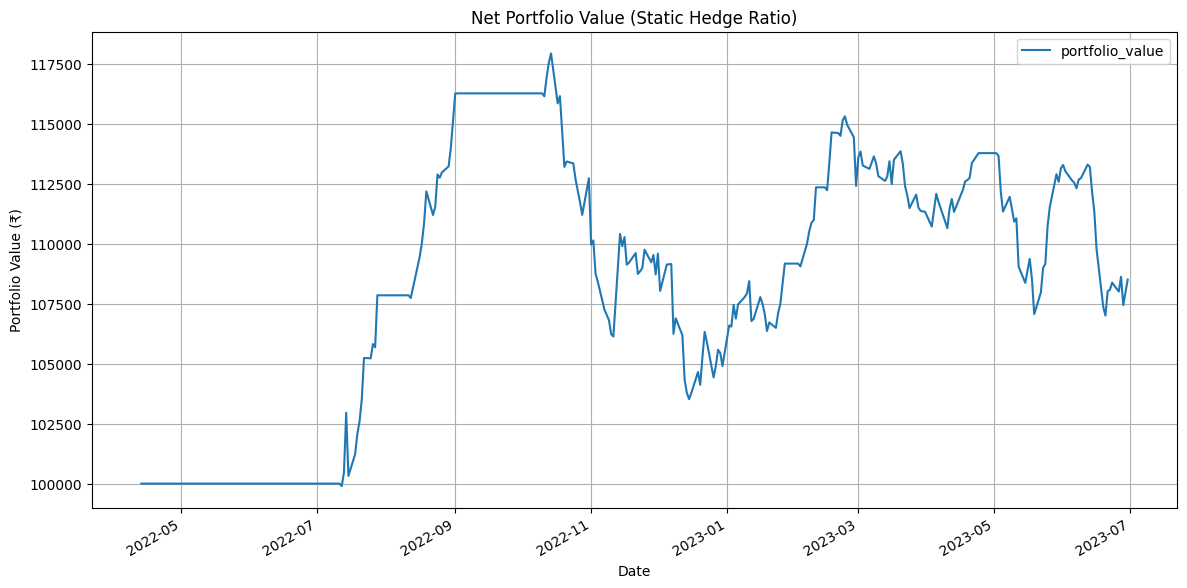

In [34]:
# Calculate normalized portfolio value
portfolio_normalized = portfolio['portfolio_value']

plt.figure(figsize=(14, 7))
portfolio_normalized.plot()

plt.title("Net Portfolio Value (Static Hedge Ratio)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (₹)")
plt.legend()
plt.grid(True)
plt.show()

PnL Calculation and total Transaction costs

In [35]:
total_gross_pnl = sum(trade['Gross PnL'] for trade in trade_log if trade['Type'].startswith('Exit'))
total_costs = sum(trade['Transaction Cost'] for trade in trade_log)
total_net_pnl = total_gross_pnl - total_costs

print(f"Total Gross P&L (Before Costs): ₹{total_gross_pnl:,.2f}")
print(f"Total Transaction Costs Incurred: ₹{total_costs:,.2f}")
print(f"Total Net P&L (After Costs): ₹{total_net_pnl:,.2f}")

Total Gross P&L (Before Costs): ₹14,957.36
Total Transaction Costs Incurred: ₹1,288.03
Total Net P&L (After Costs): ₹13,669.33


Visualizing the Daily Drawdown and finding the Maximum Drawdown (MDD)

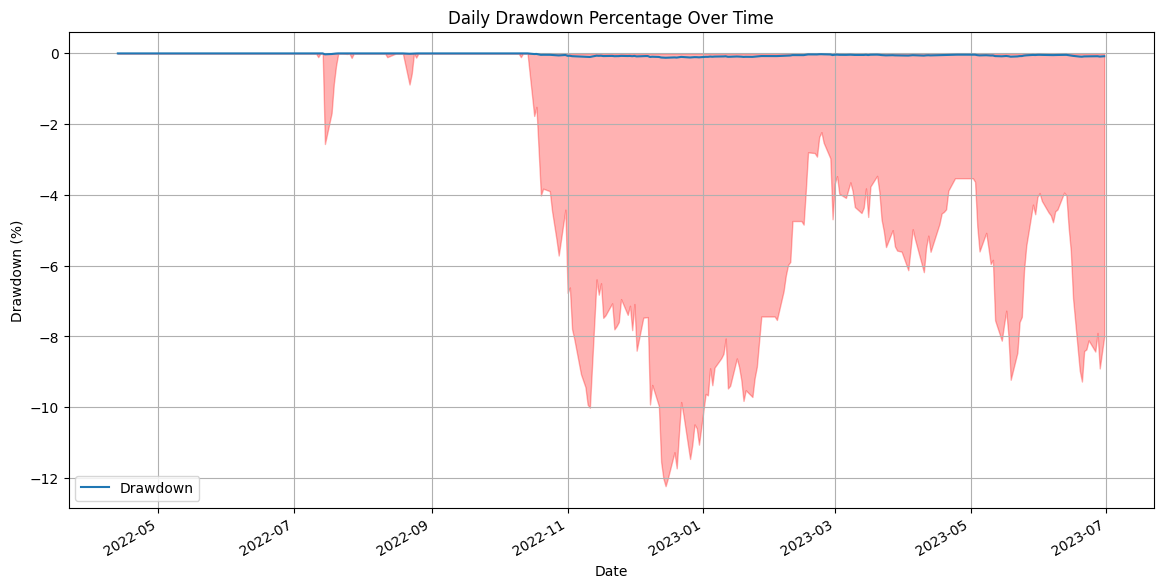

Maximum Drawdown (MDD): -12.23%


In [36]:
# Calculate daily returns
portfolio['daily_return'] = portfolio['portfolio_value'].pct_change().fillna(0)

# Calculate cumulative returns
cumulative_returns = (1 + portfolio['daily_return']).cumprod()

# Calculate rolling maximum portfolio value
rolling_max = cumulative_returns.cummax()

# Calculate drawdown
drawdown = (cumulative_returns - rolling_max) / rolling_max
drawdown_percent = drawdown*100

# Calculate maximum drawdown
max_drawdown = drawdown.min()

plt.figure(figsize=(14, 7))
drawdown.plot(label='Drawdown')

plt.title("Daily Drawdown Percentage Over Time")
plt.xlabel("Date")
plt.ylabel("Drawdown (%)")
plt.fill_between(drawdown.index, drawdown_percent, color='red', alpha=0.3)
plt.legend()
plt.grid(True)
plt.show()

print(f"Maximum Drawdown (MDD): {max_drawdown:.2%}")

Calculating the Compound Annual Growth Rate (CAGR)

In [37]:
start_value = portfolio['portfolio_value'].dropna().iloc[0]
end_value = portfolio['portfolio_value'].iloc[-1]
start_date_for_cagr = portfolio['portfolio_value'].first_valid_index()

number_of_years = (portfolio.index[-1] - start_date_for_cagr).days / 365.25

cagr = (end_value / start_value)**(1/number_of_years) - 1

print(f"CAGR (Compound Annual Growth Rate): {cagr:.2%}")

CAGR (Compound Annual Growth Rate): 6.97%


Calculating the Sharpe Ratio (SR)

In [38]:
aligned_returns = portfolio['daily_return'].dropna()
annualized_return = aligned_returns.mean() * 252 # Assuming 252 trading days
annualized_std_dev = aligned_returns.std() * np.sqrt(252)
risk_free_rate = 0.04 # 4% annualized

# Handle cases where annualized_std_dev is zero
if annualized_std_dev != 0:
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_std_dev
else:
    sharpe_ratio = np.nan # Undefined Sharpe Ratio


print(f"Annualized Sharpe Ratio (assuming 4% risk-free rate): {sharpe_ratio:.4f}")

Annualized Sharpe Ratio (assuming 4% risk-free rate): 0.3066


<h3>Summary of using a Static Hedge Ratio</h3>

In [39]:
# Calculate Final Capital
final_capital = portfolio['portfolio_value'].iloc[-1]

# Calculate Net Profit and Loss (%)
net_pnl_pct = (total_net_pnl / INITIAL_CAPITAL) * 100

# Count total trades executed (each entry and exit is a trade, so count entries/exits in trade_log)
total_trades_executed = len(trade_log) # Assuming each entry/exit is logged

performance_data = {
    'Performance Metric': [
        'Initial Capital (₹)',
        'Final Capital (₹)',
        'Net Profit and Loss (%)',
        'CAGR (%)',
        'Annualized Sharpe Ratio',
        'Maximum Drawdown (MDD)',
        'Total Transaction Costs (₹)',
        'Total Trades Executed'
    ],
    'Static Hedge Ratio': [
        INITIAL_CAPITAL,
        final_capital,
        net_pnl_pct,
        cagr * 100,
        sharpe_ratio,
        max_drawdown * 100,
        total_costs,
        total_trades_executed
    ]
}

performance_df = pd.DataFrame(performance_data).set_index('Performance Metric')

print("Final Performance Matrix: Static OLS Pairs Strategy")
display(performance_df)

Final Performance Matrix: Static OLS Pairs Strategy


,Static Hedge Ratio
Performance Metric,
Initial Capital (₹),100000.000000
Final Capital (₹),108515.332640
Net Profit and Loss (%),13.669331
CAGR (%),6.970035
Annualized Sharpe Ratio,0.306588
Maximum Drawdown (MDD),-12.229765
Total Transaction Costs (₹),1288.033342
Total Trades Executed,11.000000


# Kalman Filter

A simple kalman filter to smoothen a price series

In [40]:
def KalmanFilterAverage(x):

    # Initialize the Kalman Filter for averaging
    kf = KalmanFilter(transition_matrices = [1], # Assumes the next state is the same as the current state
                      observation_matrices = [1], # Assumes the observation is the same as the state
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01 )

    # Apply the filter to the input series
    state_means, _ = kf.filter(x.values)

    # Convert the filtered state means back to a pandas Series with the original index
    state_means = pd.Series(state_means.flatten(), index=x.index)

    # Return the smoothed series
    return state_means

Estimates the dynamic hedge ratio and the intercept of the residual spread

In [41]:
def KalmanFilterRegression(x,y):

    # Process noise covariance parameter (delta)
    delta = 1e-3

    # Transition covariance matrix
    trans_cov = delta / (1 - delta) * np.eye(2)

    # Observation matrix
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    # Initialize the Kalman Filter for regression
    kf = KalmanFilter(n_dim_obs=1,
                      n_dim_state=2,
                      initial_state_mean=[0,0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=trans_cov)

    # Apply the filter to the observed data (y)
    state_means, state_covs = kf.filter(y.values)

    # Return the estimated state means (dynamic intercept and hedge ratio)
    return state_means

Visualizing the Spread

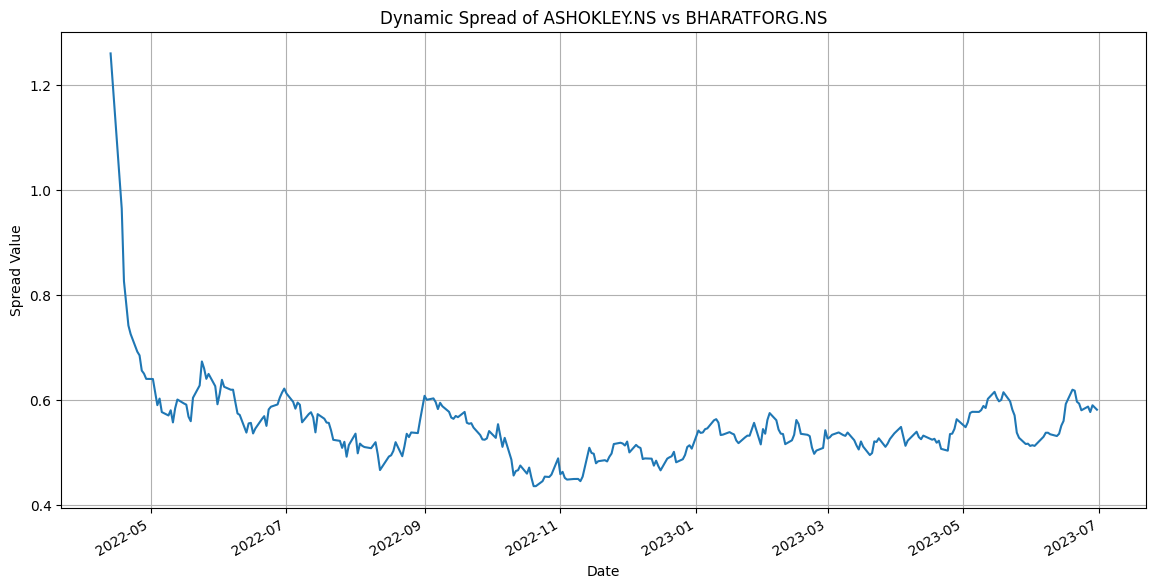

In [42]:
stock_pair = [ticker_x, ticker_y]

y = test_log_prices[ticker_y]
x = test_log_prices[ticker_x]

# Create a DataFrame to hold all signals and prices
signals_df = pd.DataFrame(index=y.index)
signals_df['y'] = y
signals_df['x'] = x
signals_df['y_closed'] = test_close_prices[ticker_y] # For plotting
signals_df['x_closed'] = test_close_prices[ticker_x] # For plotting

# Apply Kalman Filter Regression
state_means = KalmanFilterRegression(KalmanFilterAverage(x), KalmanFilterAverage(y))
signals_df['hr'] = -state_means[:, 0]
signals_df['spread'] = signals_df['y'] + (signals_df['x'] * signals_df['hr'])

# Plotting
spread = signals_df["spread"]
spread.plot(figsize=(14, 7))

plt.title(f'Dynamic Spread of {ticker_y} vs {ticker_x}')
plt.xlabel('Date')
plt.ylabel('Spread Value')
plt.grid(True)
plt.show();

Visualizing the Z-score of the residual spread with trading thresholds

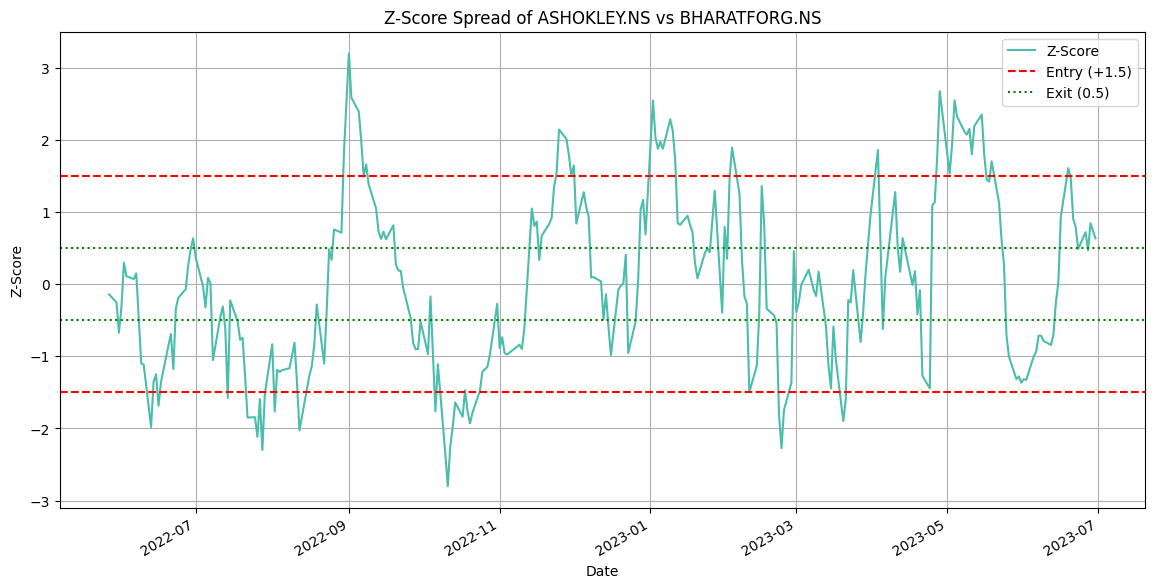

In [43]:
# Entry and Exit thresholds
entryZscore = 1.5
exitZscore = 0.5

# Calculate rolling mean and standard deviation
zscore_window=30
meanSpread = signals_df['spread'].rolling(window=zscore_window).mean()
stdSpread = signals_df['spread'].rolling(window=zscore_window).std()


# Calculate the Z-score
signals_df['zScore'] = (signals_df['spread'] - meanSpread) / stdSpread

# Plotting
plt.figure(figsize=(14, 7))
signals_df['zScore'].plot(label='Z-Score', c='#4abdac')

plt.axhline(entryZscore, color='red', linestyle='--', label=f'Entry (+{entryZscore})')
plt.axhline(-entryZscore, color='red', linestyle='--')
plt.axhline(exitZscore, color='green', linestyle=':', label=f'Exit ({exitZscore})')
plt.axhline(-exitZscore, color='green', linestyle=':')

plt.title(f'Z-Score Spread of {ticker_y} vs {ticker_x}')
plt.ylabel('Z-Score')
plt.xlabel('Date')
plt.legend(loc='best')
plt.grid(True)
plt.show()

<h3>Rolling Walk-forward backtesting</h3>

Portfolio tracking and trading logs initialization

In [44]:
INITIAL_CAPITAL = 100000.0
RISK_FREE_RATE = 0.04

# Identify long entry signals
signals_df['long entry'] = ((signals_df.zScore < - entryZscore) & ( signals_df.zScore.shift(1) > - entryZscore))

# Identify long exit signals
signals_df['long exit'] = ((signals_df.zScore > - exitZscore) & (signals_df.zScore.shift(1) < - exitZscore))

# Determine number of units to go long
signals_df['num units long'] = np.nan
signals_df.loc[signals_df['long entry'],'num units long'] = 7
signals_df.loc[signals_df['long exit'],'num units long'] = 0
signals_df['num units long'][0] = 0
signals_df['num units long'] = signals_df['num units long'].fillna(method='pad')

# Identify short entry signals
signals_df['short entry'] = ((signals_df.zScore > entryZscore) & ( signals_df.zScore.shift(1) < entryZscore))

# Identify short exit signals
signals_df['short exit'] = ((signals_df.zScore < exitZscore) & (signals_df.zScore.shift(1) > exitZscore))
signals_df['num units short'] = np.nan
signals_df.loc[signals_df['short entry'],'num units short'] = -7
signals_df.loc[signals_df['short exit'],'num units short'] = 0
signals_df['num units short'][0] = 0
signals_df['num units short'] = signals_df['num units short'].fillna(method='pad')

Running the backtest

In [45]:
# Drop rows with NaN values
signals_df.dropna(how="any", inplace=True)

# Calculate total number of units (long + short)
signals_df['numUnits'] = signals_df['num units long'] + signals_df['num units short']

# Calculate the percentage change in the spread
signals_df['spread pct ch'] = (signals_df['spread'] - signals_df['spread'].shift(1)) / ((signals_df['x'] * abs(signals_df['hr'])) + signals_df['y'])

# Calculate portfolio returns
signals_df['port rets'] = signals_df['spread pct ch'] * signals_df['numUnits'].shift(1)

# Calculate cumulative returns
signals_df['cum rets'] = signals_df['port rets'].cumsum()

# Add 1 to cumulative returns
signals_df['cum rets'] = signals_df['cum rets'] + 1

display(signals_df.tail())

,y,x,y_closed,x_closed,hr,spread,zScore,long entry,long exit,num units long,short entry,short exit,num units short,numUnits,spread pct ch,port rets,cum rets
Date,,,,,,,,,,,,,,,,,
2023-06-23,4.321023,6.673823,75.265572,791.415100,-0.560513,0.580256,0.487005,False,False,0.0,False,True,0.0,0.0,-0.001572,0.011004,1.201311
2023-06-26,4.337288,6.684055,76.499817,799.554810,-0.561034,0.587308,0.719955,False,False,0.0,False,False,0.0,0.0,0.000872,0.000000,1.201311
2023-06-27,4.333323,6.689498,76.197067,803.918884,-0.561539,0.576906,0.469976,False,False,0.0,False,True,0.0,0.0,-0.001286,-0.000000,1.201311
2023-06-28,4.347585,6.685710,77.291588,800.878784,-0.562059,0.589823,0.844710,False,False,0.0,False,False,0.0,0.0,0.001594,0.000000,1.201311
2023-06-30,4.356285,6.710084,77.966927,820.639648,-0.562573,0.581374,0.634009,False,False,0.0,False,False,0.0,0.0,-0.001039,-0.000000,1.201311


Visualizing trading signals on the spread

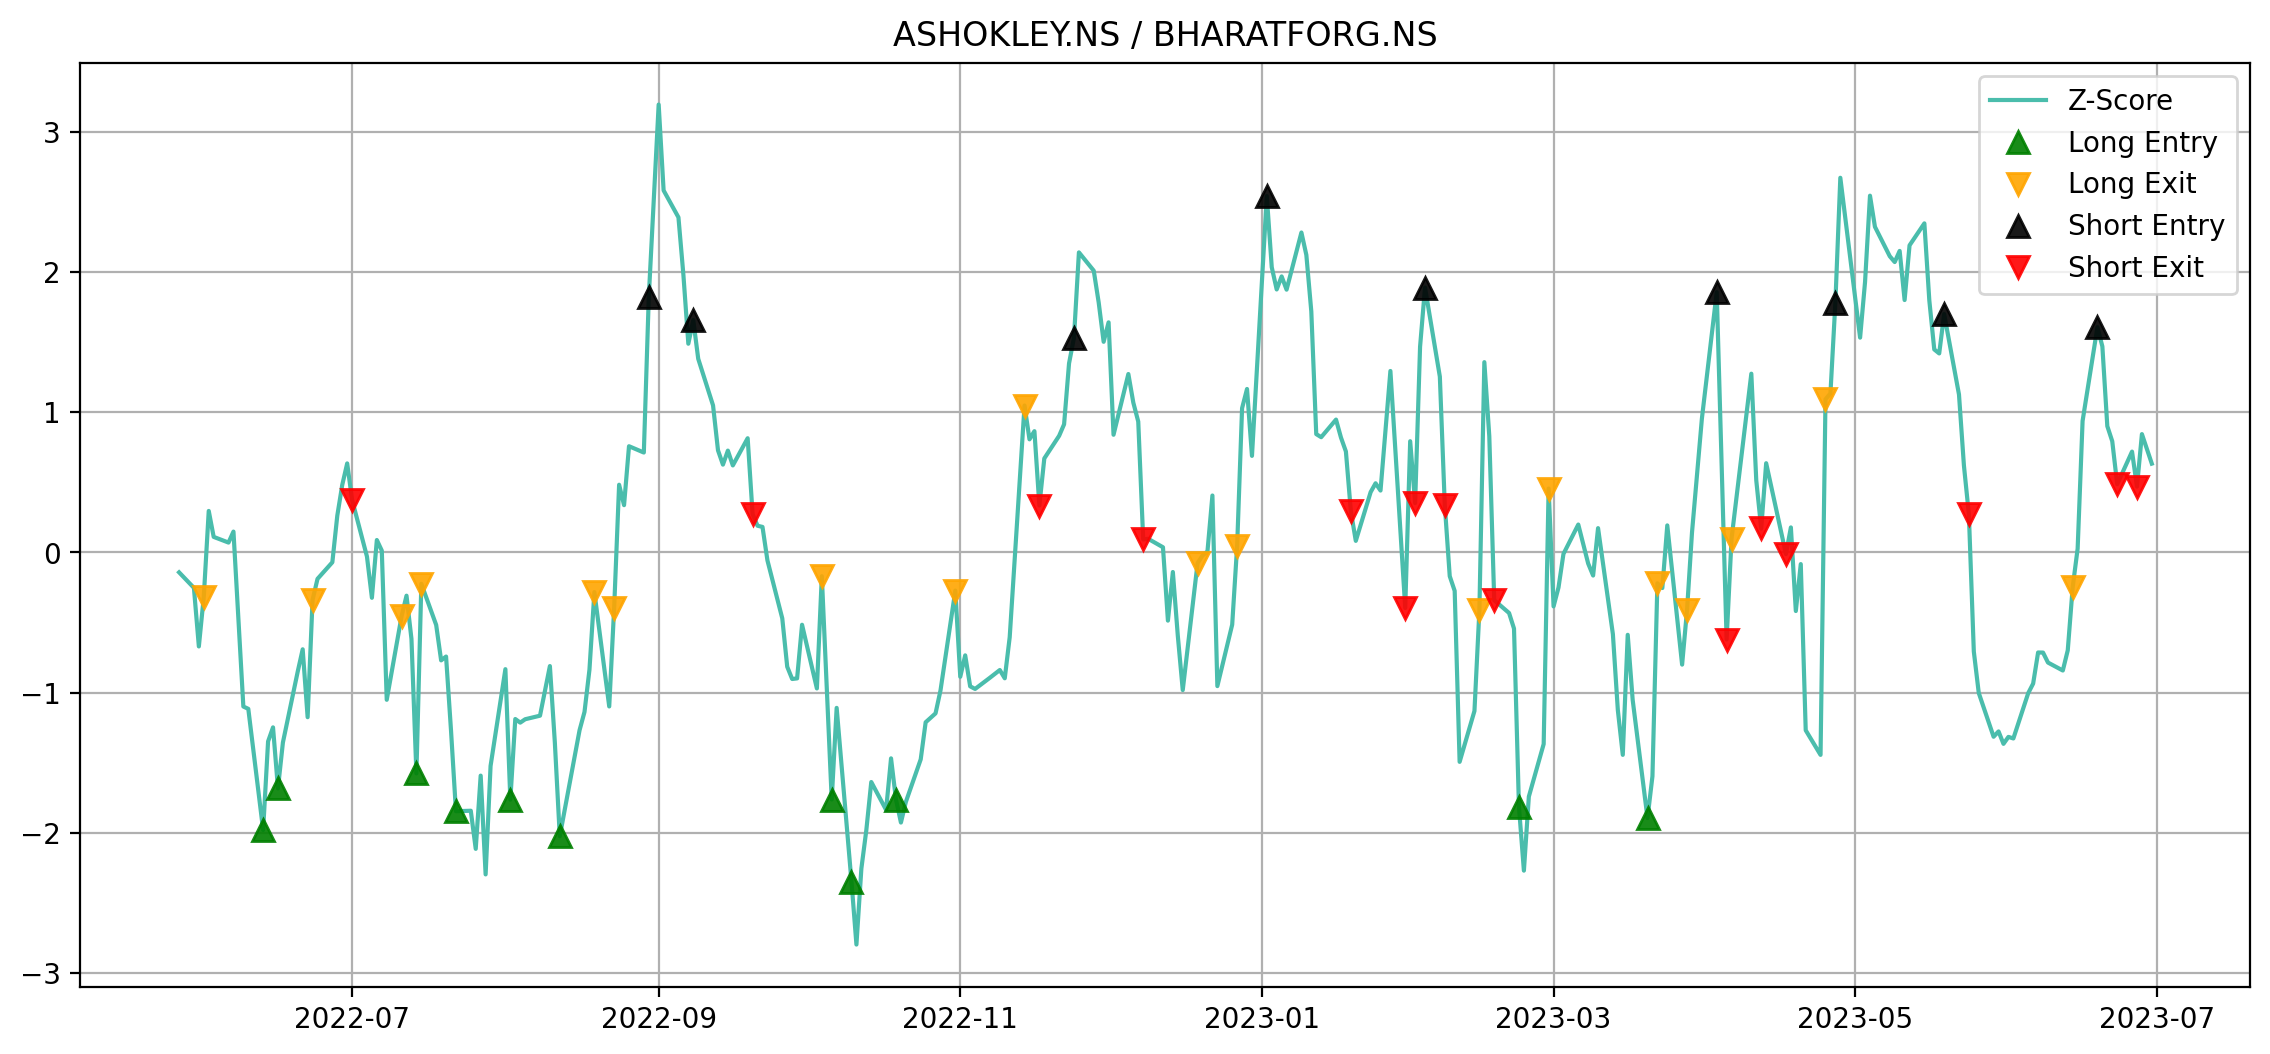

In [46]:
def plot_pair_trades(trade_signals):
    fig = plt.figure(figsize=(14, 6),dpi=200)
    bx = fig.add_subplot(111)
    series = bx.plot(trade_signals['zScore'], c='#4abdac')

    long_entry = bx.plot(trade_signals['zScore'][trade_signals['long entry'] == True], lw = 0, marker = '^', markersize = 8, c = 'g', alpha = 0.9)
    long_exit = bx.plot(trade_signals['zScore'][trade_signals['long exit'] == True], lw = 0, marker = 'v', markersize = 8, c = 'orange', alpha = 0.9)
    short_entry = bx.plot(trade_signals['zScore'][trade_signals["short entry"]== True], lw = 0, marker = '^', markersize = 8, c = 'black', alpha = 0.9)
    short_exit = bx.plot(trade_signals['zScore'][trade_signals["short exit"]== True], lw = 0, marker = 'v', markersize = 8, c = 'r', alpha = 0.9)

    stock1 = stock_pair[0]
    stock2 = stock_pair[1]

    plt.title(f'{stock2} / {stock1}')
    plt.legend(['Z-Score', 'Long Entry', 'Long Exit','Short Entry',"Short Exit"])
    plt.grid(True)
    plt.show()

plot_pair_trades(signals_df)

Visualizing trading signals on the individual price series

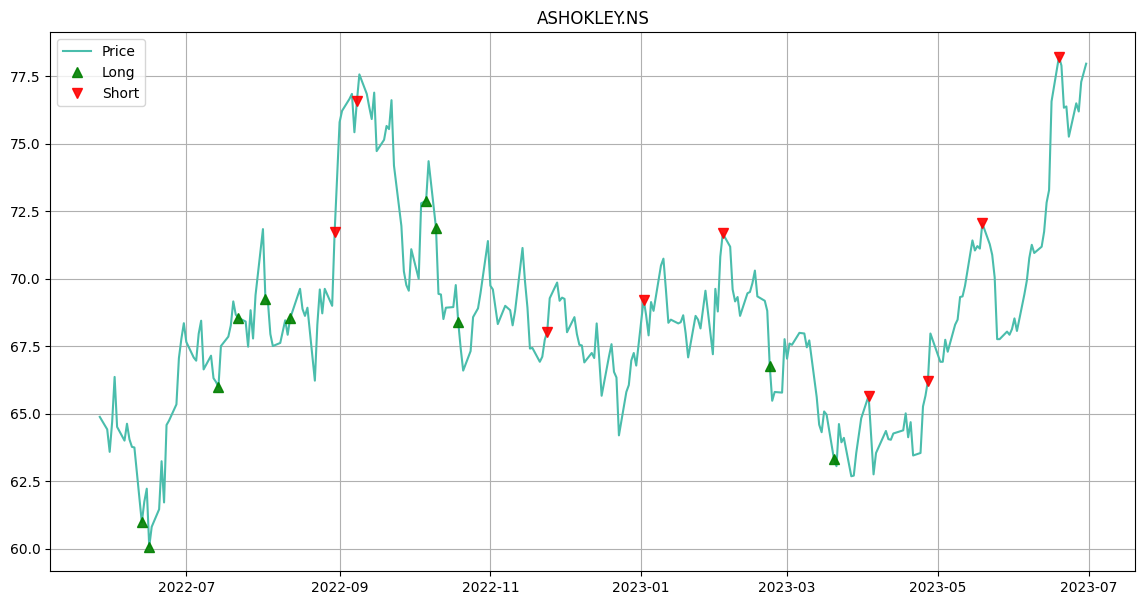

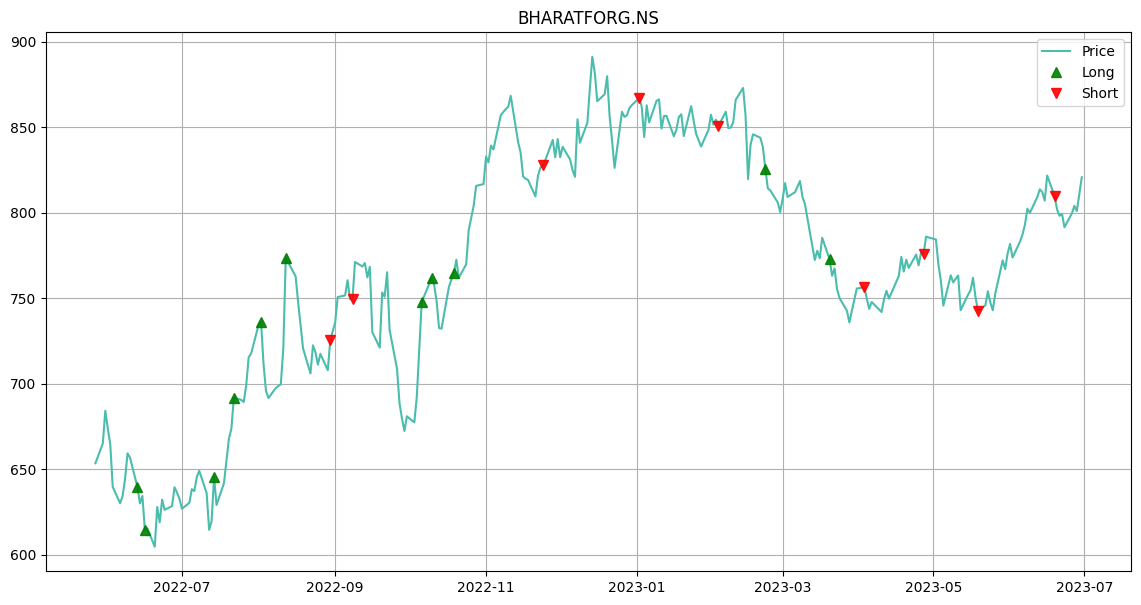

In [47]:
def plot_trades_1(signals):
    fig = plt.figure(figsize=(14,7))
    bx = fig.add_subplot(111)

    l1 = bx.plot(signals['y_closed'], c='#4abdac')
    u1 = bx.plot(signals['y_closed'][signals['long entry'] == True], lw=0, marker='^', markersize=7, c='g',alpha=0.9)
    u2, = bx.plot(signals['y_closed'][signals['short entry'] == True], lw=0, marker='v', markersize=7, c='r',alpha=0.9)

    plt.title(stock_pair[1])
    plt.legend(['Price', 'Long', 'Short'])
    plt.grid(True)
    plt.show()

plot_trades_1(signals_df)

def plot_trades_2(signals):
    fig=plt.figure(figsize=(14,7))
    bx = fig.add_subplot(111)

    l1 = bx.plot(signals['x_closed'], c='#4abdac')
    u1 = bx.plot(signals['x_closed'][signals['long entry'] == True], lw=0, marker='^', markersize=7, c='g',alpha=0.9)
    u2 = bx.plot(signals['x_closed'][signals['short entry'] == True], lw=0, marker='v', markersize=7, c='r',alpha=0.9)

    plt.title(stock_pair[0])
    plt.legend(['Price', 'Long', 'Short'])
    plt.grid(True)
    plt.show()

plot_trades_2(signals_df)

Visualizing Portfolio Curve

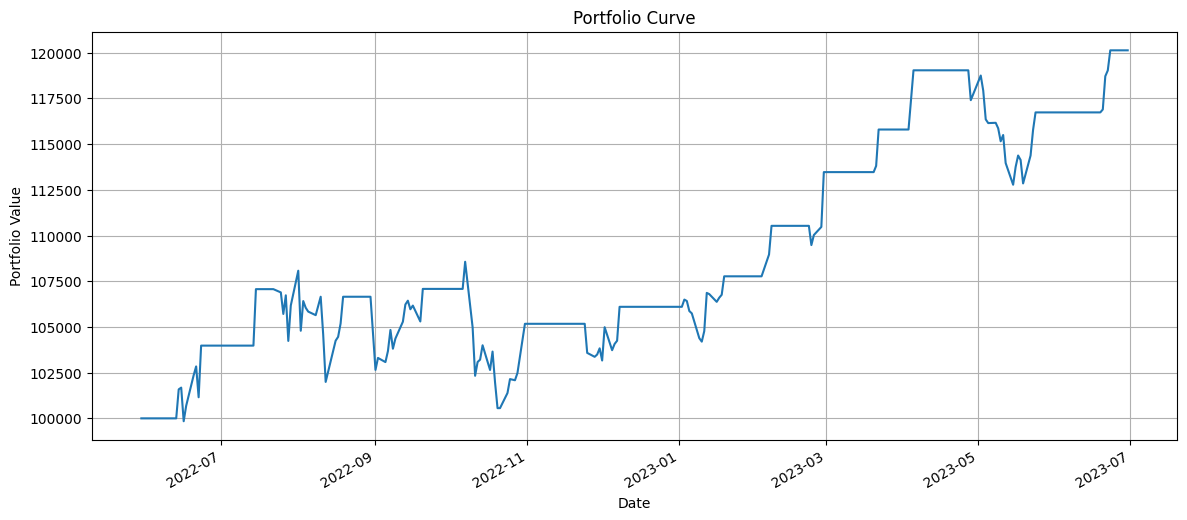

In [48]:
# Cumulative Returns
current_portfolio_value = signals_df["cum rets"]*100000

current_portfolio_value.plot(figsize=(14, 6))

plt.title('Portfolio Curve')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.show()

Calculating Transaction Costs and Net Profit and Loss

In [49]:
start_val = 1
end_val = signals_df['cum rets'].iat[-1]
gross_pnl_kf = (end_val - start_val) * 100000 # Based on 'cum rets' and 100k capital

# Your simplified cost model
estimated_turnover = (signals_df['x'].diff().abs() * abs(signals_df['numUnits'].shift(1)) * (100000 // signals_df['x'][0])).sum() + \
                     (signals_df['y'].diff().abs() * abs(signals_df['numUnits'].shift(1)) * (100000 // signals_df['y'][0])).sum()

transaction_cost_rate = 0.0005
total_transaction_costs_kf = estimated_turnover * transaction_cost_rate * 2

net_pnl_kf = gross_pnl_kf - total_transaction_costs_kf

print(f"Gross P&L (from cum rets): {gross_pnl_kf:.2f}")
print(f"Total Transaction Costs (Estimated): {total_transaction_costs_kf:.2f}")
print(f"Net P&L (Estimated): {net_pnl_kf:.2f}")

Gross P&L (from cum rets): 20131.10
Total Transaction Costs (Estimated): 399.61
Net P&L (Estimated): 19731.49


Visualizing Daily Drawdown and finding the Maximum Drawdown

Maximum Drawdown calculated: -7.38%


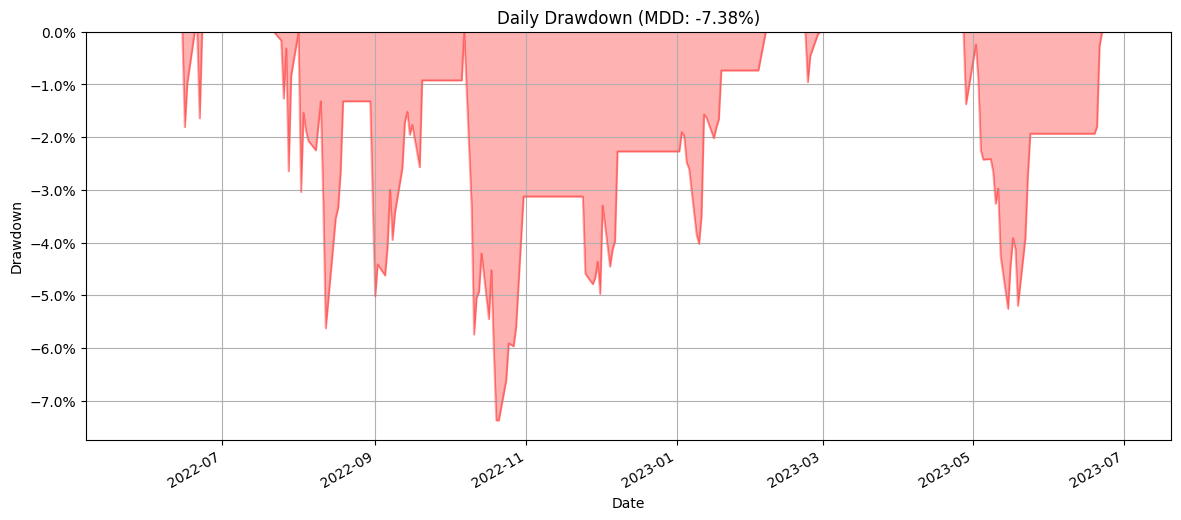

In [50]:
# Calculating the daily drawdown
running_max = signals_df["cum rets"].cummax()
drawdown = signals_df["cum rets"] / running_max - 1
MDD_kf = drawdown.min() * 100

print(f"Maximum Drawdown calculated: {MDD_kf:.2f}%")

# Plot the drawdown
plt.figure(figsize=(14, 6))
drawdown.plot(kind='area', color='red', alpha=0.3)
plt.title(f'Daily Drawdown (MDD: {MDD_kf:.2f}%)')
plt.ylabel('Drawdown')
plt.xlabel('Date')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid(True)
plt.show()

Compound Annual Growth Ratio (CAGR)

In [51]:
start_val = 1
end_val = signals_df['cum rets'].iat[-1]

# Get dates from the signals_df
start_date = signals_df.index[0]
end_date = signals_df.index[-1]
days = (end_date - start_date).days
if days == 0: days = 1 # Avoid division by zero

# Using your 252.0/days formula for CAGR
cagr_kf = (end_val / start_val) ** (252.0/days) - 1

print(f"Compound Annual Growth Rate (CAGR): {cagr_kf*100:.2f}%")

Compound Annual Growth Rate (CAGR): 12.28%


Sharpe Ratio (SR)

In [52]:
sharpe_ratio_kf = ((signals_df['port rets'].mean() / signals_df['port rets'].std()) * np.sqrt(252))
print(f"Annualized Sharpe Ratio: {sharpe_ratio_kf:.2f}")

Annualized Sharpe Ratio: 1.31


Summary of Dynamic Hedge Ratio using Kalman Filters

In [53]:
final_capital_kf = INITIAL_CAPITAL + net_pnl_kf

long_entries_kf = signals_df['long entry'].sum()
long_exits_kf = signals_df['long exit'].sum()
short_entries_kf = signals_df['short entry'].sum()
short_exits_kf = signals_df['short exit'].sum()

total_trades_executed_kf = long_entries_kf + long_exits_kf + short_entries_kf + short_exits_kf

performance_data_kf = {
    'Performance Metric': [
        'Initial Capital (₹)',
        'Final Capital (₹)',
        'Net Profit and Loss (%)',
        'CAGR (%)',
        'Annualized Sharpe Ratio',
        'Maximum Drawdown (MDD)',
        'Total Transaction Costs (₹)',
        'Total Trades Executed'
    ],
    'Kalman Filter': [
        INITIAL_CAPITAL,
        final_capital_kf,
        (net_pnl_kf / INITIAL_CAPITAL) * 100 ,
        cagr_kf * 100,
        sharpe_ratio_kf,
        MDD_kf,
        total_transaction_costs_kf,
        total_trades_executed_kf
    ]
}

performance_df_kf = pd.DataFrame(performance_data_kf).set_index('Performance Metric')

print("Final Performance Matrix: Kalman Filters Strategy")
display(performance_df_kf)

Final Performance Matrix: Kalman Filters Strategy


,Kalman Filter
Performance Metric,
Initial Capital (₹),100000.000000
Final Capital (₹),119731.491789
Net Profit and Loss (%),19.731492
CAGR (%),12.281628
Annualized Sharpe Ratio,1.314657
Maximum Drawdown (MDD),-7.375959
Total Transaction Costs (₹),399.605070
Total Trades Executed,53.000000


# Comparing Static Hedge Ratio with Dynamic Hedge Ratio

In [54]:
# Concatenate them on their index (axis=1)
comparison_table = pd.concat([performance_df_kf, performance_df], axis=1)

print("\n--- Strategy Performance Comparison ---")
display(comparison_table)


--- Strategy Performance Comparison ---


,Kalman Filter,Static Hedge Ratio
Performance Metric,,
Initial Capital (₹),100000.000000,100000.000000
Final Capital (₹),119731.491789,108515.332640
Net Profit and Loss (%),19.731492,13.669331
CAGR (%),12.281628,6.970035
Annualized Sharpe Ratio,1.314657,0.306588
Maximum Drawdown (MDD),-7.375959,-12.229765
Total Transaction Costs (₹),399.605070,1288.033342
Total Trades Executed,53.000000,11.000000


# Vector Error-Correction Model

### Data Preparation and Splitting
Prepare the data for the VECM model and split it into training and testing sets as done for the previous strategies. We will use the log prices of the selected cointegrated pair.

In [55]:
# Create DataFrames with the log prices of the selected cointegrated pair for VECM training and testing
vecm_train_data = pd.DataFrame({ticker_y: y_train_series, ticker_x: x_train_series})
vecm_test_data = pd.DataFrame({ticker_y: y_test_series, ticker_x: x_test_series})

print(f"Full dataset length: {len(log_prices[[ticker_y, ticker_x]])} days.")
print(f"Training period: {vecm_train_data.index[0].strftime('%Y-%m-%d')} to {vecm_train_data.index[-1].strftime('%Y-%m-%d')} ({len(vecm_train_data)} days).")
print(f"Testing period: {vecm_test_data.index[0].strftime('%Y-%m-%d')} to {vecm_test_data.index[-1].strftime('%Y-%m-%d')} ({len(vecm_test_data)} days).")

print("\nSample of VECM Training Data (Head):")
display(vecm_train_data.head())

print("\nSample of VECM Testing Data (Head):")
display(vecm_test_data.head())

Full dataset length: 1504 days.
Training period: 2017-06-01 to 2022-04-12 (1203 days).
Testing period: 2022-04-13 to 2023-06-30 (301 days).

Sample of VECM Training Data (Head):


,ASHOKLEY.NS,BHARATFORG.NS
Date,,
2017-06-01,3.654752,6.338130
2017-06-02,3.673780,6.327542
2017-06-05,3.675394,6.322543
2017-06-06,3.662951,6.305039
2017-06-07,3.672702,6.341979



Sample of VECM Testing Data (Head):


,ASHOKLEY.NS,BHARATFORG.NS
Date,,
2022-04-13,4.078178,6.567281
2022-04-18,4.077786,6.560986
2022-04-19,4.053192,6.557549
2022-04-20,4.079744,6.564823
2022-04-21,4.084815,6.575095


### Fitting the VECM Model
Fit the VECM model to the training data. This involves selecting the appropriate lag length and determining the cointegration rank using the Johansen test, as described in the reference material (Section 3.2).

In [56]:


# Determine the optimal lag length using information criteria on the training data
# According to the PDF (Section 3.2.2, Lag Order Selection), we can use AIC, BIC, HQIC, or FPE.
# Let's use AIC for this example.
lag_select = vecm.select_order(vecm_train_data, maxlags=5, deterministic="c")
print("Lag Order Selection:")
print(lag_select.summary())

# Extract the optimal lag based on AIC
optimal_lag = lag_select.aic

print(f"\nOptimal lag length selected based on AIC: {optimal_lag}")

# Determine the cointegration rank using the Johansen test on the training data
# According to the PDF (Section 3.2.3, Cointegration Rank), we perform the Johansen test
# and compare the trace and maximum eigenvalue statistics to critical values.
# For a pair of stocks, a cointegration rank of 1 is expected if they are cointegrated.
johansen_test = vecm.coint_johansen(vecm_train_data, det_order=1, k_ar_diff=optimal_lag)

print("\nJohansen Cointegration Test Results:")
print("Eigenvalues:")
print(johansen_test.eig)
print("\nTrace Statistic:")
print(johansen_test.lr1)
print("Critical Values (90%, 95%, 99%):")
print(johansen_test.cvt)
print("\nMaximum Eigenvalue Statistic:")
print(johansen_test.lr2)
print("Critical Values (90%, 95%, 99%):")
print(johansen_test.cvm)

# Based on the Johansen test results, determine the cointegration rank.
# Assuming a cointegration rank of 1 for a cointegrated pair based on previous analysis
# and confirmation from the Johansen test results if statistics are above critical values.
cointegration_rank = 1 # Based on previous analysis and expected for a cointegrated pair
print(f"\nUsing cointegration rank: {cointegration_rank}")


# Fit the VECM model with the selected lag length and cointegration rank on the training data
# According to the PDF (Section 3.2.4, VECM Estimation)
vecm_model = vecm.VECM(vecm_train_data, deterministic="c", k_ar_diff=optimal_lag, coint_rank=cointegration_rank)
vecm_res = vecm_model.fit()

print("\nVECM Model Summary:")
display(vecm_res.summary())

# Extract the estimated cointegrating vector (beta)
# The cointegrating vector is normalized such that the first element is 1.
# For a 2-variable system (y, x), the cointegrating vector is [1, beta_x].
# The cointegrating relation is y + beta_x * x.
# The error correction term (spread) is y + beta_x * x.
# In the context of y - eta*x, the hedge ratio eta is -beta_x.
# The `vecm_res.beta` attribute contains the estimated cointegrating vectors.
# For coint_rank=1 and 2 variables, vecm_res.beta will be a 2x1 array [[1.0], [beta_x]].
vecm_beta = vecm_res.beta[1, 0] # Extract the estimated coefficient for x

# The hedge ratio for the spread y - eta*x is eta is vecm_beta in the form y - eta*x
# Since the VECM cointegrating vector is [1, beta_x], the relation is y + beta_x * x = 0,
# so y = -beta_x * x. Comparing with y = eta * x, we get eta = -beta_x.
vecm_hedge_ratio = -vecm_beta

print(f"\nEstimated VECM Hedge Ratio (eta): {vecm_hedge_ratio:.4f}")

Lag Order Selection:
 VECM Order Selection (* highlights the minimums)
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -14.94     -14.91*   3.258e-07     -14.93*
1     -14.94*      -14.89  3.256e-07*      -14.92
2      -14.93      -14.87   3.273e-07      -14.91
3      -14.93      -14.86   3.274e-07      -14.90
4      -14.93      -14.84   3.285e-07      -14.89
5      -14.93      -14.82   3.283e-07      -14.89
-------------------------------------------------

Optimal lag length selected based on AIC: 1

Johansen Cointegration Test Results:
Eigenvalues:
[0.0223157  0.00198766]

Trace Statistic:
[29.49428471  2.38956061]
Critical Values (90%, 95%, 99%):
[[16.1619 18.3985 23.1485]
 [ 2.7055  3.8415  6.6349]]

Maximum Eigenvalue Statistic:
[27.1047241   2.38956061]
Critical Values (90%, 95%, 99%):
[[15.0006 17.1481 21.7465]
 [ 2.7055  3.8415  6.6349]]

Using cointegration rank: 1

VECM Model Summary:


,coef,std err,z,P>|z|,[0.025,0.975]
L1.ASHOKLEY.NS.ASHOKLEY,0.0447,0.035,1.271,0.204,-0.024,0.114
L1.BHARATFORG.NS.ASHOKLEY,0.0459,0.042,1.090,0.276,-0.037,0.128
,coef,std err,z,P>|z|,[0.025,0.975]
L1.ASHOKLEY.NS.BHARATFORG,0.0540,0.030,1.828,0.067,-0.004,0.112
L1.BHARATFORG.NS.BHARATFORG,-0.0443,0.035,-1.254,0.210,-0.113,0.025
,coef,std err,z,P>|z|,[0.025,0.975]
ec1.ASHOKLEY,-0.0137,0.005,-2.756,0.006,-0.023,-0.004
,coef,std err,z,P>|z|,[0.025,0.975]
ec1.BHARATFORG,-0.0058,0.004,-1.394,0.163,-0.014,0.002
,coef,std err,z,P>|z|,[0.025,0.975]



Estimated VECM Hedge Ratio (eta): 0.6083


### Calculate Spread and Z-score from VECM
Calculate the spread and its Z-score for the backtesting period using the estimated cointegrating vector from the VECM model and the actual log prices in the test set.

Sample of VECM Spread and Z-score (Head):


,Spread,Z-score
Date,,
2023-06-23,0.261448,1.186528
2023-06-26,0.271489,1.398093
2023-06-27,0.264213,1.144750
2023-06-28,0.280780,1.482414
2023-06-30,0.274653,1.257975


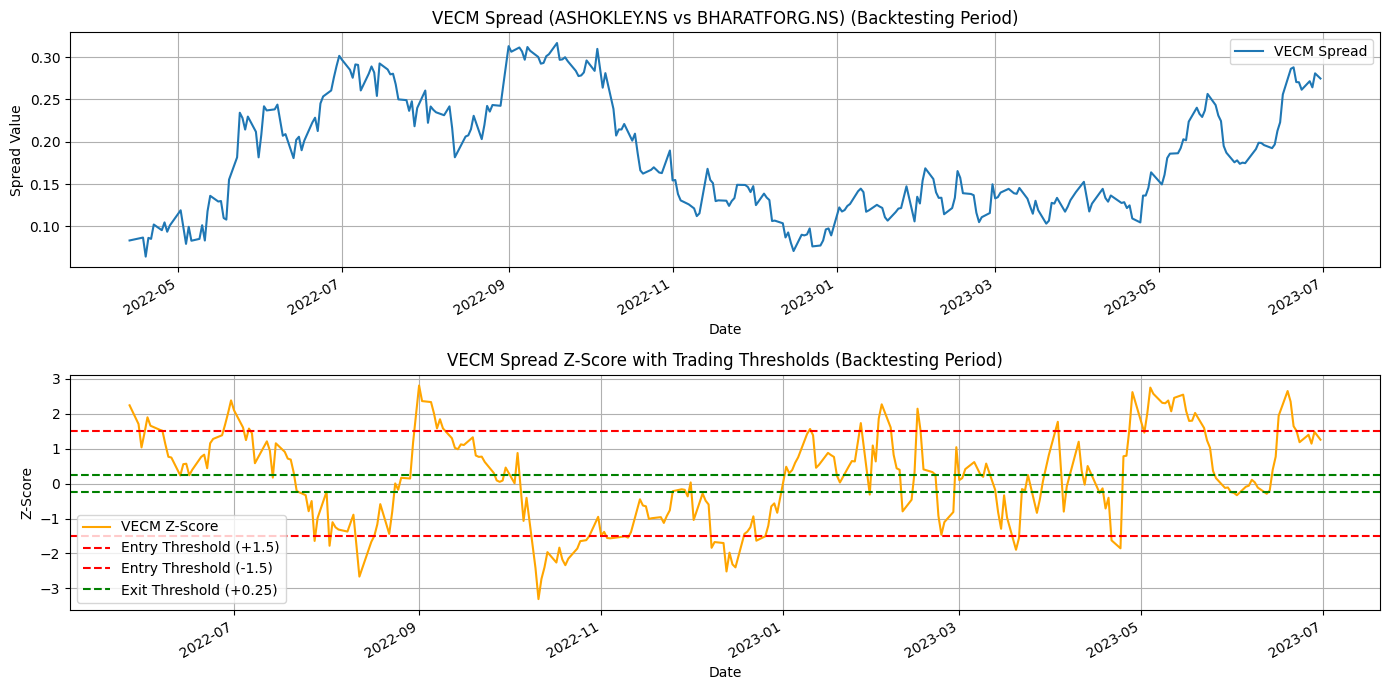

In [57]:
# Calculate the VECM spread for the backtesting period
# The spread is calculated using the actual log prices from the test set
# and the estimated cointegrating vector from the VECM model.
# Spread = y + beta_x * x
vecm_spread = vecm_test_data[ticker_y] + (vecm_test_data[ticker_x] * vecm_beta)

# Calculate the rolling mean and standard deviation of the VECM spread for Z-score calculation
vecm_zscore_window = 30  # Use the same window as the Kalman Filter for consistency
vecm_rolling_mean = vecm_spread.rolling(window=vecm_zscore_window).mean()
vecm_rolling_std = vecm_spread.rolling(window=vecm_zscore_window).std()

# Calculate the Z-score of the VECM spread
vecm_zscore = (vecm_spread - vecm_rolling_mean) / vecm_rolling_std

# Drop NaN values that result from the rolling window calculation
vecm_spread = vecm_spread.dropna()
vecm_zscore = vecm_zscore.dropna()


print("Sample of VECM Spread and Z-score (Head):")
vecm_spread_zscore_df = pd.DataFrame({'Spread': vecm_spread, 'Z-score': vecm_zscore})
display(vecm_spread_zscore_df.tail())

# Plot the VECM spread and its Z-score
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
vecm_spread.plot(label='VECM Spread')
plt.title(f'VECM Spread ({ticker_y} vs {ticker_x}) (Backtesting Period)')
plt.ylabel('Spread Value')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
vecm_zscore.plot(label='VECM Z-Score', color='orange')
plt.axhline(K_ENTER, color='red', linestyle='--', label=f'Entry Threshold (+{K_ENTER})')
plt.axhline(-K_ENTER, color='red', linestyle='--', label=f'Entry Threshold (-{K_ENTER})')
plt.axhline(K_EXIT, color='green', linestyle='--', label=f'Exit Threshold (+{K_EXIT})')
plt.axhline(-K_EXIT, color='green', linestyle='--')
plt.title('VECM Spread Z-Score with Trading Thresholds (Backtesting Period)')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Backtesting the VECM Strategy
Backtest the pairs trading strategy using the Z-score of the VECM spread. The trading logic will involve entering a long spread position when the Z-score is below -K_ENTER and a short spread position when the Z-score is above K_ENTER. Positions will be exited when the Z-score crosses back within the [-K_EXIT, K_EXIT] range.

In [58]:
# #Already used this to find parameters no need to run again

# import pandas as pd
# import numpy as np
# from itertools import product

# # ==============================
# # HYPERPARAMETER TUNING WRAPPER
# # ==============================
# def backtest_vecm_strategy(close_prices, vecm_zscore, ticker_x, ticker_y,
#                            vecm_hedge_ratio, INITIAL_CAPITAL=1_000_000,
#                            C_FIXED_PCT=0.001, ALPHA=0.001,
#                            K_ENTER=2.0, K_EXIT=0.0):

#     # Prepare aligned data
#     vecm_backtest_data = pd.DataFrame({
#         'price_y': close_prices[ticker_y].loc[vecm_zscore.index],
#         'price_x': close_prices[ticker_x].loc[vecm_zscore.index],
#         'zscore': vecm_zscore
#     }).dropna()

#     portfolio = pd.DataFrame(index=vecm_backtest_data.index)
#     portfolio['portfolio_value'] = INITIAL_CAPITAL
#     portfolio['shares_y'] = 0.0
#     portfolio['shares_x'] = 0.0
#     portfolio['position'] = 0
#     portfolio['daily_return'] = 0.0

#     trade_log = []

#     # ===== Backtesting Loop =====
#     for i in range(1, len(vecm_backtest_data)):
#         date_t = vecm_backtest_data.index[i]
#         prev_date = vecm_backtest_data.index[i-1]

#         z_t = vecm_backtest_data['zscore'].iloc[i]
#         y_t, x_t = vecm_backtest_data['price_y'].iloc[i], vecm_backtest_data['price_x'].iloc[i]
#         y_prev, x_prev = vecm_backtest_data['price_y'].iloc[i-1], vecm_backtest_data['price_x'].iloc[i-1]

#         prev_val = portfolio.loc[prev_date, 'portfolio_value']
#         prev_pos = portfolio.loc[prev_date, 'position']
#         prev_y, prev_x = portfolio.loc[prev_date, ['shares_y', 'shares_x']]

#         # Carry forward
#         portfolio.loc[date_t, ['portfolio_value', 'shares_y', 'shares_x', 'position']] = \
#             [prev_val, prev_y, prev_x, prev_pos]

#         # Calculate PnL
#         pnl = 0.0
#         if prev_pos != 0:
#             pnl = prev_y * (y_t - y_prev) + prev_x * (x_t - x_prev)
#         portfolio.loc[date_t, 'portfolio_value'] += pnl

#         # ===== Exit Conditions =====
#         if prev_pos == 1 and z_t > K_EXIT:  # Exit Long
#             portfolio.loc[date_t, ['shares_y', 'shares_x', 'position']] = [0, 0, 0]

#         elif prev_pos == -1 and z_t < -K_EXIT:  # Exit Short
#             portfolio.loc[date_t, ['shares_y', 'shares_x', 'position']] = [0, 0, 0]

#         # ===== Entry Conditions =====
#         elif prev_pos == 0:
#             current_equity = portfolio.loc[date_t, 'portfolio_value']
#             alloc = current_equity * 0.5

#             if z_t < -K_ENTER:
#                 # Long spread: Buy Y, Sell X
#                 shares_y = alloc // y_t
#                 shares_x = (shares_y * abs(vecm_hedge_ratio) * y_t) // x_t
#                 portfolio.loc[date_t, ['shares_y', 'shares_x', 'position']] = [shares_y, -shares_x, 1]
#                 trade_log.append({'Date': date_t, 'Type': 'Long Entry', 'Z': z_t})

#             elif z_t > K_ENTER:
#                 # Short spread: Sell Y, Buy X
#                 shares_y = alloc // y_t
#                 shares_x = (shares_y * abs(vecm_hedge_ratio) * y_t) // x_t
#                 portfolio.loc[date_t, ['shares_y', 'shares_x', 'position']] = [-shares_y, shares_x, -1]
#                 trade_log.append({'Date': date_t, 'Type': 'Short Entry', 'Z': z_t})

#         # Daily return
#         if i > 0:
#             portfolio.loc[date_t, 'daily_return'] = (
#                 portfolio.loc[date_t, 'portfolio_value'] - portfolio.loc[prev_date, 'portfolio_value']
#             ) / portfolio.loc[prev_date, 'portfolio_value']

#     # ===== Metrics =====
#     final_capital = portfolio['portfolio_value'].iloc[-1]
#     returns = portfolio['daily_return']
#     sharpe = np.sqrt(252) * returns.mean() / returns.std() if returns.std() != 0 else 0
#     cagr = ((final_capital / INITIAL_CAPITAL) ** (252 / len(portfolio)) - 1)
#     mdd = ((portfolio['portfolio_value'].cummax() - portfolio['portfolio_value']).max()) / portfolio['portfolio_value'].cummax().max()

#     return {
#         'K_ENTER': K_ENTER, 'K_EXIT': K_EXIT,
#         'FinalCapital': final_capital,
#         'Sharpe': sharpe, 'CAGR': cagr,
#         'MDD': mdd
#     }


# # =====================================
# # PARAMETER SEARCH (Grid/Manual Search)
# # =====================================

# K_ENTER_values = [1.5, 2.0, 2.5]
# K_EXIT_values = [0.0, 0.5, 1.0]
# window_sizes = [30, 60, 90]  # for rolling Z-score

# results = []

# for win, K_E, K_X in product(window_sizes, K_ENTER_values, K_EXIT_values):
#     # recompute Z-score for each window size
#     spread_train = train_close_prices[ticker_y] - vecm_hedge_ratio * train_close_prices[ticker_x]
#     vecm_zscore_train = (spread_train - spread_train.rolling(win).mean()) / spread_train.rolling(win).std()
#     vecm_zscore_train = vecm_zscore_train.dropna()

#     res = backtest_vecm_strategy(close_prices, vecm_zscore_train, ticker_x, ticker_y,
#                                  vecm_hedge_ratio, K_ENTER=K_E, K_EXIT=K_X)
#     res['Window'] = win
#     results.append(res)

# # Convert to DataFrame for analysis
# results_df = pd.DataFrame(results)
# best = results_df.sort_values(by='Sharpe', ascending=False).iloc[0]

# print("\n=== Hyperparameter Optimization Results ===")
# display(results_df)
# print("\nBest Hyperparameters:")
# print(best)


In [59]:
# Combine VECM Z-score with actual closing prices for backtesting
# Ensure data is aligned by index after dropping NaNs from Z-score calculation
vecm_backtest_data = pd.DataFrame({
    'price_y': close_prices[ticker_y].loc[vecm_zscore.index],
    'price_x': close_prices[ticker_x].loc[vecm_zscore.index],
    'zscore': vecm_zscore
})

# Initialize portfolio tracking for the VECM strategy
portfolio_vecm = pd.DataFrame(index=vecm_backtest_data.index)
portfolio_vecm['portfolio_value'] = INITIAL_CAPITAL
portfolio_vecm['shares_y'] = 0.0
portfolio_vecm['shares_x'] = 0.0
portfolio_vecm['position'] = 0 # 1 for long (long y, short x), -1 for short (short y, long x), 0 for flat
portfolio_vecm['trades'] = 0
portfolio_vecm['daily_return'] = 0.0

# Initialize trade log for the VECM strategy
trade_log_vecm = []

# Optimal hyperparameters from previous tuning
OPTIMAL_K_ENTER = 1.5
OPTIMAL_K_EXIT = 0.5

print(f"Starting VECM backtest with Initial Capital: \u20b9{INITIAL_CAPITAL:,.2f}")
print(f"Backtesting Period: {vecm_backtest_data.index[0].strftime('%Y-%m-%d')} to {vecm_backtest_data.index[-1].strftime('%Y-%m-%d')} ({len(vecm_backtest_data)} days).")
print(f"Using Optimal Entry Threshold (K_ENTER): {OPTIMAL_K_ENTER}")
print(f"Using Optimal Exit Threshold (K_EXIT): {OPTIMAL_K_EXIT}")

# Iterate through the backtesting data
for i in range(1, len(vecm_backtest_data)):
    date_t = vecm_backtest_data.index[i]
    prev_date_t = vecm_backtest_data.index[i-1]

    # Carry over previous day's state
    portfolio_vecm.loc[date_t, ['portfolio_value', 'shares_y', 'shares_x', 'position', 'trades']] = portfolio_vecm.loc[prev_date_t, ['portfolio_value', 'shares_y', 'shares_x', 'position', 'trades']].copy()


    # Get values for today
    z_t = vecm_backtest_data['zscore'].loc[date_t]
    price_y_t = vecm_backtest_data['price_y'].loc[date_t]
    price_x_t = vecm_backtest_data['price_x'].loc[date_t]

    # Get previous day's prices for PnL calculation
    prev_price_y_t = vecm_backtest_data['price_y'].loc[prev_date_t]
    prev_price_x_t = vecm_backtest_data['price_x'].loc[prev_date_t]


    # Get previous day's state
    prev_pos_status = portfolio_vecm.loc[prev_date_t, 'position']
    prev_shares_y = portfolio_vecm.loc[prev_date_t, 'shares_y']
    prev_shares_x = portfolio_vecm.loc[prev_date_t, 'shares_x']
    prev_portfolio_value = portfolio_vecm.loc[prev_date_t, 'portfolio_value']

    # Calculate daily PnL from holding positions
    daily_pnl = 0.0
    if prev_pos_status != 0:
        daily_pnl = (prev_shares_y * (price_y_t - prev_price_y_t)) + (prev_shares_x * (price_x_t - prev_price_x_t))

    # Update portfolio value with today's Market to Market PnL
    portfolio_vecm.loc[date_t, 'portfolio_value'] = prev_portfolio_value + daily_pnl


    # Trading Logic based on Z-score
    current_pos_status = portfolio_vecm.loc[date_t, 'position'] # Get the updated position status for today

    # Exit Logic
    # Exit Long position if currently long and Z-score crosses above K_EXIT
    if current_pos_status == 1 and z_t > OPTIMAL_K_EXIT:
        # Transaction Costs on exiting
        cost = (C_FIXED_PCT + ALPHA) * (prev_shares_y * price_y_t + abs(prev_shares_x) * price_x_t)
        portfolio_vecm.loc[date_t, 'portfolio_value'] -= cost

        # Calculate Gross PnL for the trade being exited
        # Find the corresponding entry trade in the log
        entry_trade = next((trade for trade in reversed(trade_log_vecm) if trade['Type'].startswith('Entry - Long')), None)
        gross_pnl = 0
        if entry_trade:
            gross_pnl = (price_y_t - entry_trade['Price Y']) * entry_trade['Shares Y'] + (entry_trade['Price X'] - price_x_t) * entry_trade['Shares X']

        # Log the exit trade
        trade_log_vecm.append({
            'Date': date_t,
            'Type': 'Exit - Long Spread',
            'Z-Score': z_t,
            'Shares Y': 0, # Position is flattened
            'Shares X': 0, # Position is flattened
            'Price Y': price_y_t,
            'Price X': price_x_t,
            'Hedge Ratio': vecm_hedge_ratio,
            'Transaction Cost': cost,
            'Gross PnL': gross_pnl # Gross PnL for the completed trade
        })
        print(f"{date_t.date()}: EXIT LONG SPREAD (Z={z_t:.3f}) | Gross PnL: {gross_pnl:,.2f}, Cost: {cost:,.2f}, Net PnL: {gross_pnl - cost:,.2f}")


        # Flatten the position
        portfolio_vecm.loc[date_t, 'shares_y'] = 0.0
        portfolio_vecm.loc[date_t, 'shares_x'] = 0.0
        portfolio_vecm.loc[date_t, 'position'] = 0


    # Exit Short position if currently short and Z-score crosses below -K_EXIT
    elif current_pos_status == -1 and z_t < -OPTIMAL_K_EXIT:
        # Transaction Costs on exiting
        cost = (C_FIXED_PCT + ALPHA) * (abs(prev_shares_y) * price_y_t + prev_shares_x * price_x_t)
        portfolio_vecm.loc[date_t, 'portfolio_value'] -= cost

        # Calculate Gross PnL for the trade being exited
        # Find the corresponding entry trade in the log
        entry_trade = next((trade for trade in reversed(trade_log_vecm) if trade['Type'].startswith('Entry - Short')), None)
        gross_pnl = 0
        if entry_trade:
             # For a short spread (short Y, long X), PnL is (Entry Price Y - Exit Price Y)*Shares Y + (Exit Price X - Entry Price X)*Shares X
             gross_pnl = (entry_trade['Price Y'] - price_y_t) * abs(entry_trade['Shares Y']) + (price_x_t - entry_trade['Price X']) * entry_trade['Shares X']


        # Log the exit trade
        trade_log_vecm.append({
            'Date': date_t,
            'Type': 'Exit - Short Spread',
            'Z-Score': z_t,
            'Shares Y': 0, # Position is flattened
            'Shares X': 0, # Position is flattened
            'Price Y': price_y_t,
            'Price X': price_x_t,
            'Hedge Ratio': vecm_hedge_ratio,
            'Transaction Cost': cost,
            'Gross PnL': gross_pnl # Gross PnL for the completed trade
        })
        print(f"{date_t.date()}: EXIT SHORT SPREAD (Z={z_t:.3f}) | Gross PnL: {gross_pnl:,.2f}, Cost: {cost:,.2f}, Net PnL: {gross_pnl - cost:,.2f}")

        # Flatten the position
        portfolio_vecm.loc[date_t, 'shares_y'] = 0.0
        portfolio_vecm.loc[date_t, 'shares_x'] = 0.0
        portfolio_vecm.loc[date_t, 'position'] = 0


    # Entry Logic
    # Enter Long Spread (Buy Y, Sell X) if currently flat and Z-score crosses below -K_ENTER
    current_pos_status = portfolio_vecm.loc[date_t, 'position'] # Recheck status in case we just exited
    if current_pos_status == 0 and z_t < -OPTIMAL_K_ENTER:
        # Portion Size: Allocate 50% of current portfolio value per leg
        current_equity = portfolio_vecm.loc[date_t, 'portfolio_value']
        allocation_per_leg = current_equity * 0.5

        # Calculate number of shares for Y and X.
        # We need to buy Y and sell X for a long spread position.
        # Use the absolute value of the hedge ratio to determine the relative number of shares.
        if price_y_t > 0 and price_x_t > 0: # Avoid division by zero
            shares_y = allocation_per_leg // price_y_t
            shares_x = (shares_y * abs(vecm_hedge_ratio) * price_y_t) // price_x_t

            # Ensure we can afford the transaction costs before entering
            cost = (C_FIXED_PCT + ALPHA) * (shares_y * price_y_t + shares_x * price_x_t)
            if portfolio_vecm.loc[date_t, 'portfolio_value'] >= cost:
                portfolio_vecm.loc[date_t, 'portfolio_value'] -= cost

                portfolio_vecm.loc[date_t, 'shares_y'] = shares_y
                portfolio_vecm.loc[date_t, 'shares_x'] = -shares_x # Short X
                portfolio_vecm.loc[date_t, 'position'] = 1 # Long Spread
                portfolio_vecm.loc[date_t, 'trades'] += 1

                # Log the entry trade
                trade_log_vecm.append({
                    'Date': date_t,
                    'Type': 'Entry - Long Spread',
                    'Z-Score': z_t,
                    'Shares Y': shares_y,
                    'Shares X': shares_x, # Log the absolute value of shares for clarity
                    'Price Y': price_y_t,
                    'Price X': price_x_t,
                    'Hedge Ratio': vecm_hedge_ratio,
                    'Transaction Cost': cost,
                    'Gross PnL': 0 # Gross PnL is calculated on exit
                })
                print(f"{date_t.date()}: ENTER LONG SPREAD (Z={z_t:.3f}) | Buy {shares_y:.0f} {ticker_y}, Sell {shares_x:.0f} {ticker_x}")
            else:
                print(f"{date_t.date()}: Not enough capital to cover transaction costs for Long Entry.")


    # Enter Short Spread (Sell Y, Buy X) if currently flat and Z-score crosses above K_ENTER
    elif current_pos_status == 0 and z_t > OPTIMAL_K_ENTER:
        # Portion Size: Allocate 50% of current portfolio value per leg
        current_equity = portfolio_vecm.loc[date_t, 'portfolio_value']
        allocation_per_leg = current_equity * 0.5

        # Calculate number of shares for Y and X.
        # We need to sell Y and buy X for a short spread position.
         # Use the absolute value of the hedge ratio to determine the relative number of shares.
        if price_y_t > 0 and price_x_t > 0: # Avoid division by zero
            shares_y = allocation_per_leg // price_y_t
            shares_x = (shares_y * abs(vecm_hedge_ratio) * price_y_t) // price_x_t

            # Ensure we can afford the transaction costs before entering
            cost = (C_FIXED_PCT + ALPHA) * (shares_y * price_y_t + shares_x * price_x_t)
            if portfolio_vecm.loc[date_t, 'portfolio_value'] >= cost:
                portfolio_vecm.loc[date_t, 'portfolio_value'] -= cost

                portfolio_vecm.loc[date_t, 'shares_y'] = -shares_y # Short Y
                portfolio_vecm.loc[date_t, 'shares_x'] = shares_x # Long X
                portfolio_vecm.loc[date_t, 'position'] = -1 # Short Spread
                portfolio_vecm.loc[date_t, 'trades'] += 1


                trade_log_vecm.append({
                    'Date': date_t,
                    'Type': 'Entry - Short Spread',
                    'Z-Score': z_t,
                    'Shares Y': shares_y, # Log the absolute value of shares for clarity
                    'Shares X': shares_x,
                    'Price Y': price_y_t,
                    'Price X': price_x_t,
                    'Hedge Ratio': vecm_hedge_ratio,
                    'Transaction Cost': cost,
                    'Gross PnL': 0 # Gross PnL is calculated on exit
                })
                print(f"{date_t.date()}: ENTER SHORT SPREAD (Z={z_t:.3f}) | Sell {shares_y:.0f} {ticker_y}, Buy {shares_x:.0f} {ticker_x}")
            else:
                 print(f"{date_t.date()}: Not enough capital to cover transaction costs for Short Entry.")


    # Final Daily Updates
    # Daily return is calculated based on the change in portfolio value from the previous day
    if i > 0: # Ensure there's a previous day to calculate return from
        portfolio_vecm.loc[date_t, 'daily_return'] = (portfolio_vecm.loc[date_t, 'portfolio_value'] - portfolio_vecm.loc[prev_date_t, 'portfolio_value']) / portfolio_vecm.loc[prev_date_t, 'portfolio_value']


print("\n--- VECM Backtest Complete ---")

Starting VECM backtest with Initial Capital: ₹100,000.00
Backtesting Period: 2022-05-27 to 2023-06-30 (272 days).
Using Optimal Entry Threshold (K_ENTER): 1.5
Using Optimal Exit Threshold (K_EXIT): 0.5
2022-05-30: ENTER SHORT SPREAD (Z=1.707) | Sell 776 ASHOKLEY.NS, Buy 45 BHARATFORG.NS
2022-07-26: EXIT SHORT SPREAD (Z=-0.790) | Gross PnL: -1,287.54, Cost: 83.39, Net PnL: -1,370.92
2022-07-28: ENTER LONG SPREAD (Z=-1.642) | Buy 726 ASHOKLEY.NS, Sell 41 BHARATFORG.NS
2022-08-30: EXIT LONG SPREAD (Z=1.185) | Gross PnL: 2,451.87, Cost: 81.81, Net PnL: 2,370.06
2022-09-01: ENTER SHORT SPREAD (Z=2.810) | Sell 665 ASHOKLEY.NS, Buy 41 BHARATFORG.NS
2022-10-06: EXIT SHORT SPREAD (Z=-1.068) | Gross PnL: 2,429.47, Cost: 79.13, Net PnL: 2,350.34
2022-10-10: ENTER LONG SPREAD (Z=-2.418) | Buy 717 ASHOKLEY.NS, Sell 41 BHARATFORG.NS
2023-01-05: EXIT LONG SPREAD (Z=0.597) | Gross PnL: -6,109.02, Cost: 84.95, Net PnL: -6,193.97
2023-01-10: ENTER SHORT SPREAD (Z=1.565) | Sell 684 ASHOKLEY.NS, Buy 33 BH

### Performance Evaluation (VECM Strategy)
Now we will evaluate the performance of the VECM-based pairs trading strategy using standard metrics.

#### Visualization of the Portfolio Value
Let's visualize how the portfolio value changed over the backtesting period for the VECM strategy.

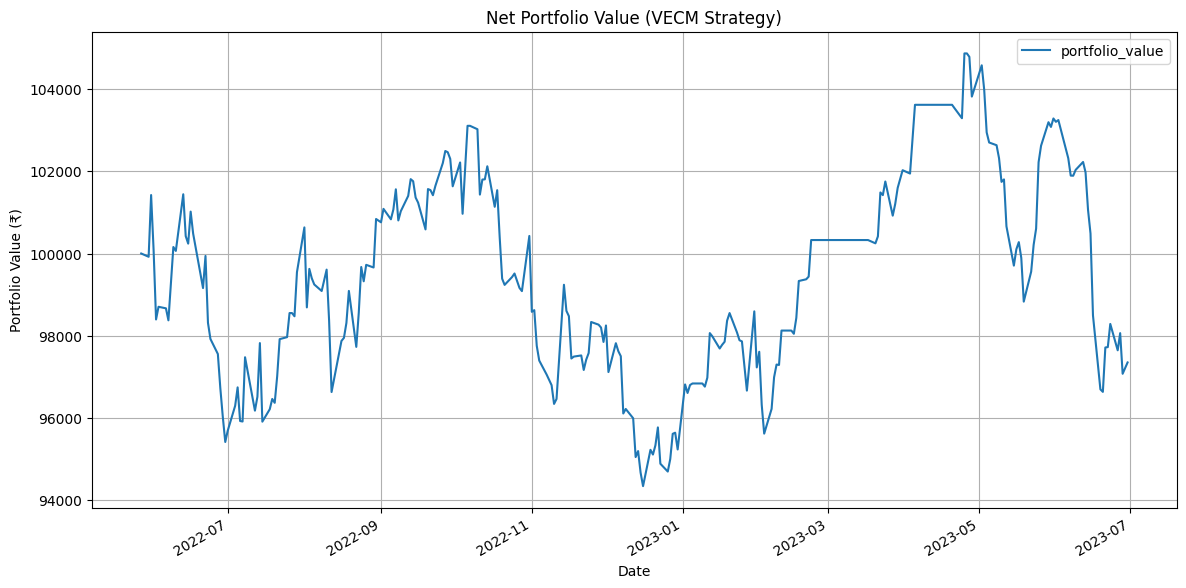

In [60]:
# Calculate and plot normalized portfolio value
portfolio_vecm_normalized = portfolio_vecm['portfolio_value']

plt.figure(figsize=(14, 7))
portfolio_vecm_normalized.plot()

plt.title("Net Portfolio Value (VECM Strategy)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (₹)")
plt.legend()
plt.grid(True)
plt.show()

#### PnL Calculation and total Transaction costs
Calculate the total Gross Profit and Loss (PnL) and total transaction costs for the VECM strategy trades.

In [61]:
total_gross_pnl_vecm = sum(trade['Gross PnL'] for trade in trade_log_vecm if trade['Type'].startswith('Exit'))
total_costs_vecm = sum(trade['Transaction Cost'] for trade in trade_log_vecm)
total_net_pnl_vecm = total_gross_pnl_vecm - total_costs_vecm

print(f"Total Gross P&L (Before Costs): ₹{total_gross_pnl_vecm:,.2f}")
print(f"Total Transaction Costs Incurred: ₹{total_costs_vecm:,.2f}")
print(f"Total Net P&L (After Costs): ₹{total_net_pnl_vecm:,.2f}")

Total Gross P&L (Before Costs): ₹6,321.82
Total Transaction Costs Incurred: ₹1,531.73
Total Net P&L (After Costs): ₹4,790.09


#### Visualizing the Daily Drawdown and finding the Maximum Drawdown (MDD)
Visualize the daily drawdown and calculate the Maximum Drawdown (MDD) for the VECM strategy.

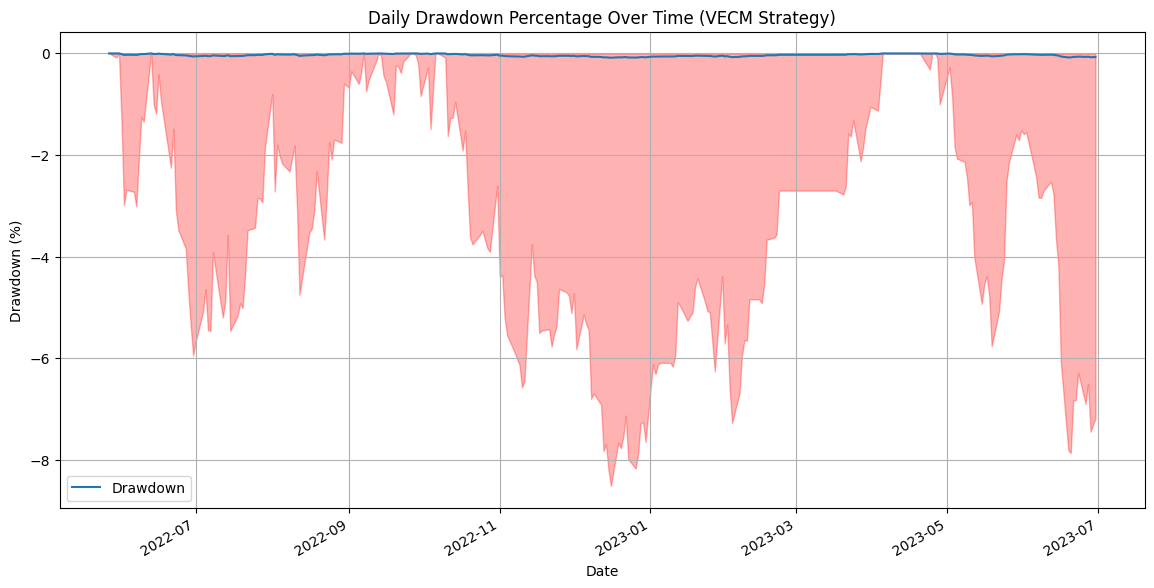

Maximum Drawdown (MDD): -8.51%


In [62]:
# Calculate daily returns
portfolio_vecm['daily_return'] = portfolio_vecm['portfolio_value'].pct_change().fillna(0)

# Calculate cumulative returns
cumulative_returns_vecm = (1 + portfolio_vecm['daily_return']).cumprod()

# Calculate rolling maximum portfolio value
rolling_max_vecm = cumulative_returns_vecm.cummax()

# Calculate drawdown
drawdown_vecm = (cumulative_returns_vecm - rolling_max_vecm) / rolling_max_vecm
drawdown_vecm_percent = drawdown_vecm*100

# Calculate maximum drawdown
max_drawdown_vecm = drawdown_vecm.min()

plt.figure(figsize=(14, 7))
drawdown_vecm.plot(label='Drawdown')

plt.title("Daily Drawdown Percentage Over Time (VECM Strategy)")
plt.xlabel("Date")
plt.ylabel("Drawdown (%)")
plt.fill_between(drawdown_vecm.index, drawdown_vecm_percent, color='red', alpha=0.3)
plt.legend()
plt.grid(True)
plt.show()

print(f"Maximum Drawdown (MDD): {max_drawdown_vecm:.2%}")

#### Calculating the Compound Annual Growth Rate (CAGR)
Calculate the Compound Annual Growth Rate (CAGR) for the VECM strategy.

In [63]:
start_value_vecm = portfolio_vecm['portfolio_value'].dropna().iloc[0]
end_value_vecm = portfolio_vecm['portfolio_value'].iloc[-1]
start_date_for_cagr_vecm = portfolio_vecm['portfolio_value'].first_valid_index()

number_of_years_vecm = (portfolio_vecm.index[-1] - start_date_for_cagr_vecm).days / 365.25

cagr_vecm = (end_value_vecm / start_value_vecm)**(1/number_of_years_vecm) - 1

print(f"CAGR (Compound Annual Growth Rate): {cagr_vecm:.2%}")

CAGR (Compound Annual Growth Rate): -2.43%


#### Calculating the Sharpe Ratio (SR)
Calculate the Sharpe Ratio (SR) for the VECM strategy.

In [64]:
aligned_returns_vecm = portfolio_vecm['daily_return'].dropna()
annualized_return_vecm = aligned_returns_vecm.mean() * 252 # Assuming 252 trading days
annualized_std_dev_vecm = aligned_returns_vecm.std() * np.sqrt(252)
risk_free_rate = 0.04 # 4% annualized

# Handle cases where annualized_std_dev is zero
if annualized_std_dev_vecm != 0:
    sharpe_ratio_vecm = (annualized_return_vecm - risk_free_rate) / annualized_std_dev_vecm
else:
    sharpe_ratio_vecm = np.nan # Undefined Sharpe Ratio

print(f"Annualized Sharpe Ratio (assuming {risk_free_rate:.0%} risk-free rate): {sharpe_ratio_vecm:.4f}")

Annualized Sharpe Ratio (assuming 4% risk-free rate): -0.5048


### Summary of using a Vector Error-Correction Model (VECM)
Summarize the performance metrics for the VECM strategy in a table.

In [65]:
# Calculate Final Capital
final_capital_vecm = portfolio_vecm['portfolio_value'].iloc[-1]

# Calculate Net Profit and Loss (%)
net_pnl_pct_vecm = (total_net_pnl_vecm / INITIAL_CAPITAL) * 100

# Count total trades executed (each entry and exit is a trade, so count entries/exits in trade_log)
total_trades_executed_vecm = len(trade_log_vecm) # Assuming each entry/exit is logged

performance_data_vecm = {
    'Performance Metric': [
        'Initial Capital (₹)',
        'Final Capital (₹)',
        'Net Profit and Loss (%)',
        'CAGR (%)',
        'Annualized Sharpe Ratio',
        'Maximum Drawdown (MDD)',
        'Total Transaction Costs (₹)',
        'Total Trades Executed'
    ],
    'VECM Strategy': [
        INITIAL_CAPITAL,
        final_capital_vecm,
        net_pnl_pct_vecm,
        cagr_vecm * 100,
        sharpe_ratio_vecm,
        max_drawdown_vecm * 100,
        total_costs_vecm,
        total_trades_executed_vecm
    ]
}

performance_df_vecm = pd.DataFrame(performance_data_vecm).set_index('Performance Metric')

print("Final Performance Matrix: VECM Strategy")
display(performance_df_vecm)

Final Performance Matrix: VECM Strategy


,VECM Strategy
Performance Metric,
Initial Capital (₹),100000.000000
Final Capital (₹),97345.680728
Net Profit and Loss (%),4.790093
CAGR (%),-2.432554
Annualized Sharpe Ratio,-0.504773
Maximum Drawdown (MDD),-8.513390
Total Transaction Costs (₹),1531.729359
Total Trades Executed,19.000000


### Comparing all Strategies
Compare the performance of the Static Hedge Ratio, Kalman Filter, and VECM strategies.

In [66]:
# Concatenate all performance tables
comparison_table_all = pd.concat([performance_df, performance_df_kf, performance_df_vecm], axis=1)

print("\n--- Strategy Performance Comparison ---")
display(comparison_table_all)


--- Strategy Performance Comparison ---


,Static Hedge Ratio,Kalman Filter,VECM Strategy
Performance Metric,,,
Initial Capital (₹),100000.000000,100000.000000,100000.000000
Final Capital (₹),108515.332640,119731.491789,97345.680728
Net Profit and Loss (%),13.669331,19.731492,4.790093
CAGR (%),6.970035,12.281628,-2.432554
Annualized Sharpe Ratio,0.306588,1.314657,-0.504773
Maximum Drawdown (MDD),-12.229765,-7.375959,-8.513390
Total Transaction Costs (₹),1288.033342,399.605070,1531.729359
Total Trades Executed,11.000000,53.000000,19.000000


### Finish task
The task is complete. We have implemented and backtested three different pairs trading strategies (Static Hedge Ratio, Kalman Filter, and VECM) and compared their performance.